In [ ]:
!pip install rarfile
!sudo apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
import pandas as pd
from itertools import combinations
from collections import Counter
import os
from google.colab import drive
from rarfile import RarFile
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn import metrics
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from torch.nn.functional import softmax
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to your RAR file in Google Drive
rar_path = '/content/drive/MyDrive/news_data.rar'  # Update this path
extract_path = '/content/news_extracted'  # Temporary extraction folder

# Create extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the RAR file
try:
    with RarFile(rar_path) as rf:
        # Find the first CSV file in the archive
        csv_files = [f for f in rf.namelist() if f.lower().endswith('.csv')]

        if not csv_files:
            raise FileNotFoundError("No CSV files found in the RAR archive")

        # Extract the first CSV file found
        csv_filename = csv_files[0]
        rf.extract(csv_filename, path=extract_path)

        # Full path to the extracted CSV
        extracted_csv_path = os.path.join(extract_path, csv_filename)

        # Load the CSV into a pandas DataFrame
        df_news = pd.read_csv(extracted_csv_path)

        print(f"Successfully extracted and loaded: {csv_filename}")
        print(f"DataFrame shape: {df_news.shape}")

        # Display first few rows
        print("\nFirst few rows:")
        print(df_news.head())

except Exception as e:
    print(f"Error: {str(e)}")
finally:
    # Clean up - remove extracted files
    if os.path.exists(extract_path):
        for file in os.listdir(extract_path):
            os.remove(os.path.join(extract_path, file))
        os.rmdir(extract_path)

Mounted at /content/drive
Successfully extracted and loaded: news_20250225to20250510.csv
DataFrame shape: (241650, 12)

First few rows:
                         ID           releasedAt  \
0  67bf0e677abefca47e66327d  2025-02-25 00:00:00   
1  67bf0e677abefca47e66327e  2025-02-25 00:00:00   
2  67bf0e677abefca47e66327f  2025-02-25 00:00:00   
3  67bf0e677abefca47e663280  2025-02-25 00:00:00   
4  67bf0e677abefca47e663281  2025-02-25 00:00:00   

                                               title  \
0  Traders are Elevating Their Portfolio with LIS...   
1  2025’s Crypto Battle: Altcoin vs. XRP and Bitc...   
2  Top Cryptos to Buy Now: The Best Choices for 2025   
3  Explore The Best Crypto Presale to Buy Now wit...   
4  ITI Launches Master’s in Trading Program for A...   

                                            subtitle         sourceName  \
0  The digital asset space sees constant shifts, ...     CryptoNewsLand   
1  Digital currencies now play a key role in glob...  Crypto Fro

In [ ]:
df_news['count'] = 1
df_news[['count', 'releasedAt']].groupby('releasedAt').sum().reset_index().sort_values('count', ascending=True)

releasedAt  count
122938  2025-04-15 09:14:59      1
122927  2025-04-15 09:12:21      1
122928  2025-04-15 09:12:25      1
122929  2025-04-15 09:12:58      1
122930  2025-04-15 09:13:08      1
...                     ...    ...
102733  2025-04-08 08:12:00     33
145254  2025-04-25 06:10:08     33
110309  2025-04-10 08:10:00     34
77179   2025-03-30 12:00:00     36
116977  2025-04-12 13:30:00     37

[188456 rows x 2 columns]

In [ ]:
df_news.head()

ID           releasedAt  \
0  67bf0e677abefca47e66327d  2025-02-25 00:00:00   
1  67bf0e677abefca47e66327e  2025-02-25 00:00:00   
2  67bf0e677abefca47e66327f  2025-02-25 00:00:00   
3  67bf0e677abefca47e663280  2025-02-25 00:00:00   
4  67bf0e677abefca47e663281  2025-02-25 00:00:00   

                                               title  \
0  Traders are Elevating Their Portfolio with LIS...   
1  2025’s Crypto Battle: Altcoin vs. XRP and Bitc...   
2  Top Cryptos to Buy Now: The Best Choices for 2025   
3  Explore The Best Crypto Presale to Buy Now wit...   
4  ITI Launches Master’s in Trading Program for A...   

                                            subtitle         sourceName  \
0  The digital asset space sees constant shifts, ...     CryptoNewsLand   
1  Digital currencies now play a key role in glob...  Crypto Front News   
2  The cryptocurrency market in 2025 offers excit...      TheNewsCrypto   
3  Pepeto Presale: The Next Meme Coin with x1000 ...     WalletInvestor   
4  Barcelona, Spain, 25th February 2025, FinanceWire     WalletInvestor   

                                           sourceUrl         source  \
0  https://cryptonewsland.com/listing1000-350-bda...  coinmarketcap   
1  https://coinmarketcap.com/community/en/article...  coinmarketcap   
2  https://coinmarketcap.com/community/en/article...  coinmarketcap   
3  https://coinmarketcap.com/community/en/article...  coinmarketcap   
4  https://coinmarketcap.com/community/en/article...  coinmarketcap   

                                                slug  \
0  listing1000-350-bdag-bonus-elevate-your-crypto...   
1  blockdag-vs-bitcoin-xrp-which-crypto-holds-lon...   
2   top-cryptos-to-buy-now-the-best-choices-for-2025   
3  explore-the-best-crypto-presale-to-buy-now-wit...   
4  iti-launches-masters-in-trading-program-for-am...   

                                   asset_names  \
0     Orbit, Monero, BlockDAG, would, Celestia   
1        Ethereum, Bitcoin, BlockDAG, XRP, One   
2  Litecoin, Top, BlockDAG, Chainlink, Stellar   
3            Pepe, Pepe, Pepe, Pepe, Shiba Inu   
4                     STA, Steve, Steve, Steve   

                                         asset_slugs  \
0       orbit, monero, blockdag, wouldmeme, celestia   
1             ethereum, bitcoin, blockdag, xrp, gmix   
2  litecoin, top-protocol, blockdag, chainlink, s...   
3  pepe, pepe-on-base, pepesol-cto, pepe-solana, ...   
4           sta-token, steve, steve-token, steve-bsc   

                   asset_symbols  \
0   ORBIT, XMR, BDAG, WOULD, TIA   
1      ETH, BTC, BDAG, XRP, GMIX   
2      LTC, TOP, BDAG, LINK, XLM   
3  PEPE, PEPE, $PEPE, PEPE, SHIB   
4       STA, STEVE, STEVE, STEVE   

                                             content  count  
0  The digital asset space sees constant shifts, ...      1  
1  Digital currencies now play a key role in glob...      1  
2  The cryptocurrency market in 2025 offers excit...      1  
3  Pepeto Presale: The Next Meme Coin with x1000 ...      1  
4  Barcelona, Spain, February 25th, 2025, Finance...      1

# Find Most Common Pairs

In [ ]:
# Assuming df is your DataFrame
# Clean and process asset symbols
def clean_symbols(asset_symbols_str):
    if pd.isna(asset_symbols_str):
        return []
    # Split, strip whitespace, and remove empty strings
    symbols = [s.strip().upper() for s in asset_symbols_str.split(',') if s.strip()]
    # Remove duplicates while preserving order
    seen = set()
    return [s for s in symbols if not (s in seen or seen.add(s))]

# Function to find unique asset pairs
def find_asset_pairs(symbols):
    # Get all unique pairs (order doesn't matter, no self-pairs)
    return list(combinations(sorted(symbols), 2))

# Initialize counter
pair_counter = Counter()

# Process each row
for _, row in df_news.iterrows():
    symbols = clean_symbols(row['asset_symbols'])
    if len(symbols) >= 2:  # Need at least 2 symbols to make a pair
        pairs = find_asset_pairs(symbols)
        pair_counter.update(pairs)

# Convert to DataFrame
pair_counts = pd.DataFrame(
    [{'Asset 1': pair[0], 'Asset 2': pair[1], 'Count': count}
     for pair, count in pair_counter.items()],
    columns=['Asset 1', 'Asset 2', 'Count']
).sort_values('Count', ascending=False).reset_index(drop=True)


In [ ]:
pair_counts

Asset 1    Asset 2  Count
0          DJT  TRUMP2024   2717
1        TRUMP  TRUMP2024   2710
2          DJT      TRUMP   2703
3          BTC       READ   2654
4          BTC    BULLISH   2417
...        ...        ...    ...
328593     ILV       ONDO      1
328594     ILV       PEPE      1
328595   APRIL        SIU      1
328596    ATOM      COLLE      1
328597    BANK      COLLE      1

[328598 rows x 3 columns]

# Find News Count for Each Stock

In [ ]:
def extract_symbols(asset_symbols_str):
    if pd.isna(asset_symbols_str):
        return []
    # Split, clean, and remove duplicates
    symbols = [s.strip().upper() for s in asset_symbols_str.split(',') if s.strip()]
    return list(set(symbols))  # Return unique symbols only

# Initialize a counter for individual assets
asset_counter = Counter()

# Process each row in the DataFrame
for _, row in df_news.iterrows():
    symbols = extract_symbols(row['asset_symbols'])
    asset_counter.update(symbols)

# Convert to DataFrame for nice display
asset_counts = pd.DataFrame.from_records(
    [{'Asset': asset, 'News Count': count}
     for asset, count in asset_counter.items()],
    columns=['Asset', 'News Count']
)

# Sort by count descending
asset_counts = asset_counts.sort_values('News Count', ascending=False).reset_index(drop=True)

In [ ]:
asset_counts

Asset  News Count
0              BTC       18106
1             READ       12622
2              ETH        8337
3              XRP        7138
4          BULLISH        6840
...            ...         ...
25225  NASDAQ:ISRL           1
25226     OTC:NWBO           1
25227     OTC:RLBY           1
25228     OTC:STGC           1
25229     OTC:BUDZ           1

[25230 rows x 2 columns]

# News Count of Each Source

In [ ]:
# Assuming your DataFrame is named 'df'
# Count news articles per source
source_counts = df_news['sourceName'].value_counts().reset_index()
source_counts.columns = ['Source', 'News Count']  # Rename columns
source_counts = source_counts.sort_values('News Count', ascending=False)

# Display the results
source_counts

Source  News Count
0                  Reuters       44815
1      Dow Jones Newswires       21377
2    London Stock Exchange       20607
3             MT Newswires       19311
4            GlobeNewswire       16057
..                     ...         ...
154                   Nexo           1
155           FXCryptoNews           1
156  Yaroslav Kalynychenko           1
157          Traders Union           1
158         CMC Alexandria           1

[159 rows x 2 columns]

In [ ]:
# Calculate percentage of total news
total_news = len(df_news)
source_counts['Percentage'] = (source_counts['News Count'] / total_news * 100).round(2)

# Display with percentage
source_counts

Source  News Count  Percentage
0                  Reuters       44815       18.55
1      Dow Jones Newswires       21377        8.85
2    London Stock Exchange       20607        8.53
3             MT Newswires       19311        7.99
4            GlobeNewswire       16057        6.64
..                     ...         ...         ...
154                   Nexo           1        0.00
155           FXCryptoNews           1        0.00
156  Yaroslav Kalynychenko           1        0.00
157          Traders Union           1        0.00
158         CMC Alexandria           1        0.00

[159 rows x 3 columns]

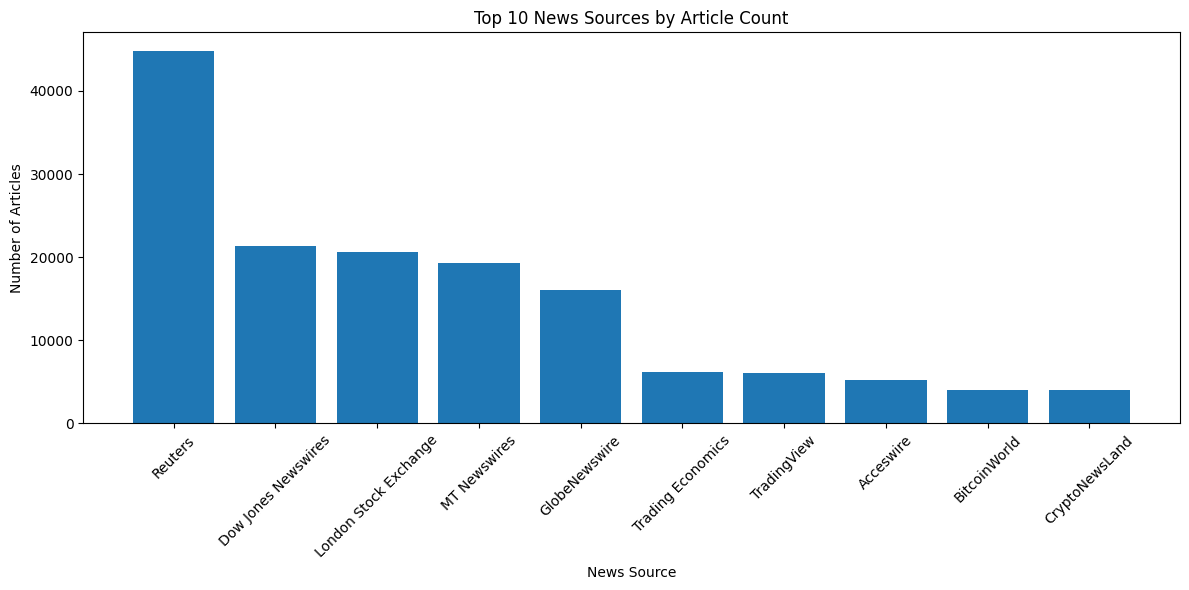

In [ ]:
# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(source_counts['Source'][:10], source_counts['News Count'][:10])  # Top 10 only
plt.title('Top 10 News Sources by Article Count')
plt.xlabel('News Source')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Assuming your DataFrame is named 'df'
# Count news articles per source
source_counts = df_news['source'].value_counts().reset_index()
source_counts.columns = ['Source', 'News Count']  # Rename columns
source_counts = source_counts.sort_values('News Count', ascending=False)

# Display the results
source_counts

Source  News Count
0     tradingview-stock      116999
1         coinmarketcap       76915
2    tradingview-crypto       10590
3  tradingview-economic       10351
4     tradingview-index        9606
5   tradingview-futures        8728
6      tradingview-bond        4631
7     tradingview-forex        2349
8       tradingview-etf        1481

In [ ]:
# Calculate percentage of total news
total_news = len(df_news)
source_counts['Percentage'] = (source_counts['News Count'] / total_news * 100).round(2)

# Display with percentage
source_counts

Source  News Count  Percentage
0     tradingview-stock      116999       48.42
1         coinmarketcap       76915       31.83
2    tradingview-crypto       10590        4.38
3  tradingview-economic       10351        4.28
4     tradingview-index        9606        3.98
5   tradingview-futures        8728        3.61
6      tradingview-bond        4631        1.92
7     tradingview-forex        2349        0.97
8       tradingview-etf        1481        0.61

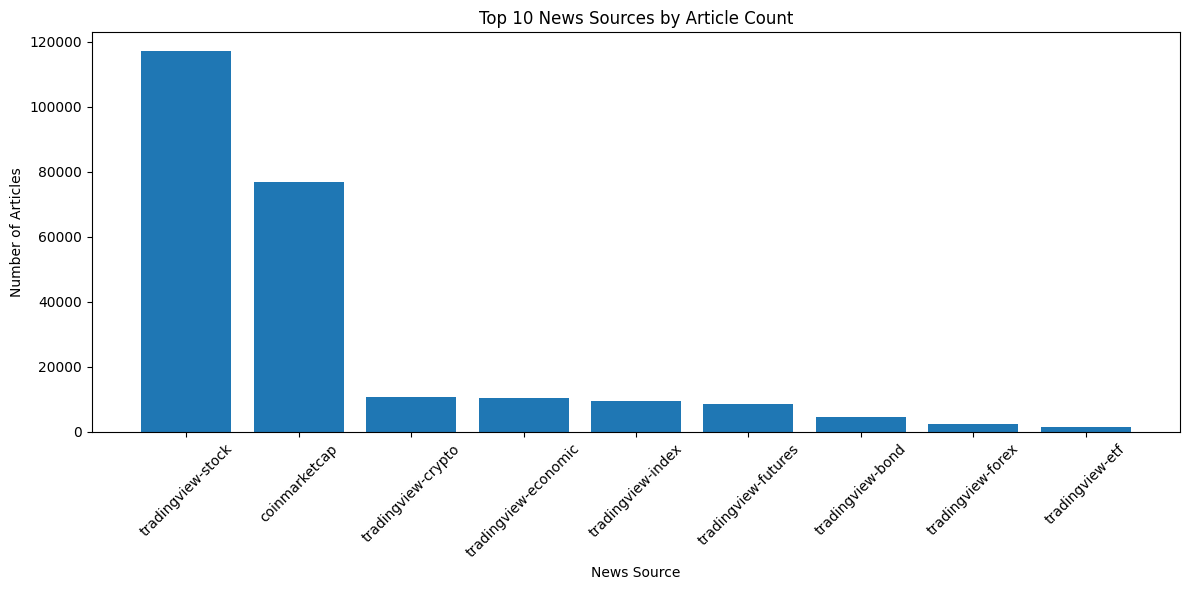

In [ ]:
# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(source_counts['Source'][:10], source_counts['News Count'][:10])  # Top 10 only
plt.title('Top 10 News Sources by Article Count')
plt.xlabel('News Source')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Assests and Source

In [ ]:
# Extract and clean asset symbols (handling duplicates and NaN)
def extract_symbols(asset_symbols_str):
    if pd.isna(asset_symbols_str):
        return []
    symbols = [s.strip().upper() for s in str(asset_symbols_str).split(',') if s.strip()]
    return list(set(symbols))  # Remove duplicates

# Group by source and count asset occurrences
source_asset_counts = defaultdict(Counter)

for _, row in df_news.iterrows():
    source = row['sourceName']
    symbols = extract_symbols(row['asset_symbols'])
    source_asset_counts[source].update(symbols)

# Convert to a structured DataFrame
source_asset_data = []
for source, counter in source_asset_counts.items():
    for asset, count in counter.most_common():  # Sorted by most frequent
        source_asset_data.append({'Source': source, 'Asset': asset, 'Count': count})

source_asset_df = pd.DataFrame(source_asset_data)

# Get the top 5 assets per source
top_assets_per_source = (
    source_asset_df
    .sort_values(['Source', 'Count'], ascending=[True, False])
    .groupby('Source')
    .head(5)
    .reset_index(drop=True)
)

In [ ]:
top_assets_per_source

Source        Asset  Count
0    11thestate      NYSE:CC      8
1    11thestate  NASDAQ:HOOD      5
2    11thestate  NASDAQ:COIN      5
3    11thestate  NASDAQ:INTC      5
4    11thestate       NYSE:A      5
..          ...          ...    ...
697     etf.com     AMEX:GLD     23
698     hodl.fm         FORS      1
699     hodl.fm           PI      1
700     hodl.fm          XYZ      1
701  pressetext    NYSE:NRGV      2

[702 rows x 3 columns]

In [ ]:
# Group by asset and count source occurrences
asset_source_counts = defaultdict(Counter)

for _, row in df_news.iterrows():
    source = row['sourceName']
    symbols = extract_symbols(row['asset_symbols'])
    for asset in symbols:
        asset_source_counts[asset].update([source])

# Convert to DataFrame
asset_source_data = []
for asset, counter in asset_source_counts.items():
    for source, count in counter.most_common():  # Sorted by most frequent
        asset_source_data.append({'Asset': asset, 'Source': source, 'Count': count})

asset_source_df = pd.DataFrame(asset_source_data)

# Get the top 3 sources per asset
top_sources_per_asset = (
    asset_source_df
    .sort_values(['Asset', 'Count'], ascending=[True, False])
    .groupby('Asset')
    .head(3)
    .reset_index(drop=True)
)

In [ ]:
top_sources_per_asset

Asset                                             Source  Count
0      $AAPL                                     CryptoNewsLand      1
1      $AGNT                                        crypto.news      1
2      $AGNT                                        Cointribune      1
3      $AGNT                                         Kanal Coin      1
4      $BABA                                           Technext      2
...      ...                                                ...    ...
41836  ZYPTO                                     CryptoNewsLand      1
41837  ZYPTO                                  Bitcoin Info News      1
41838      Π                                       CryptoPotato      3
41839      Π                                        crypto.news      2
41840      Π  Leading Crypto News, Analysis & Research | BSC...      1

[41841 rows x 3 columns]

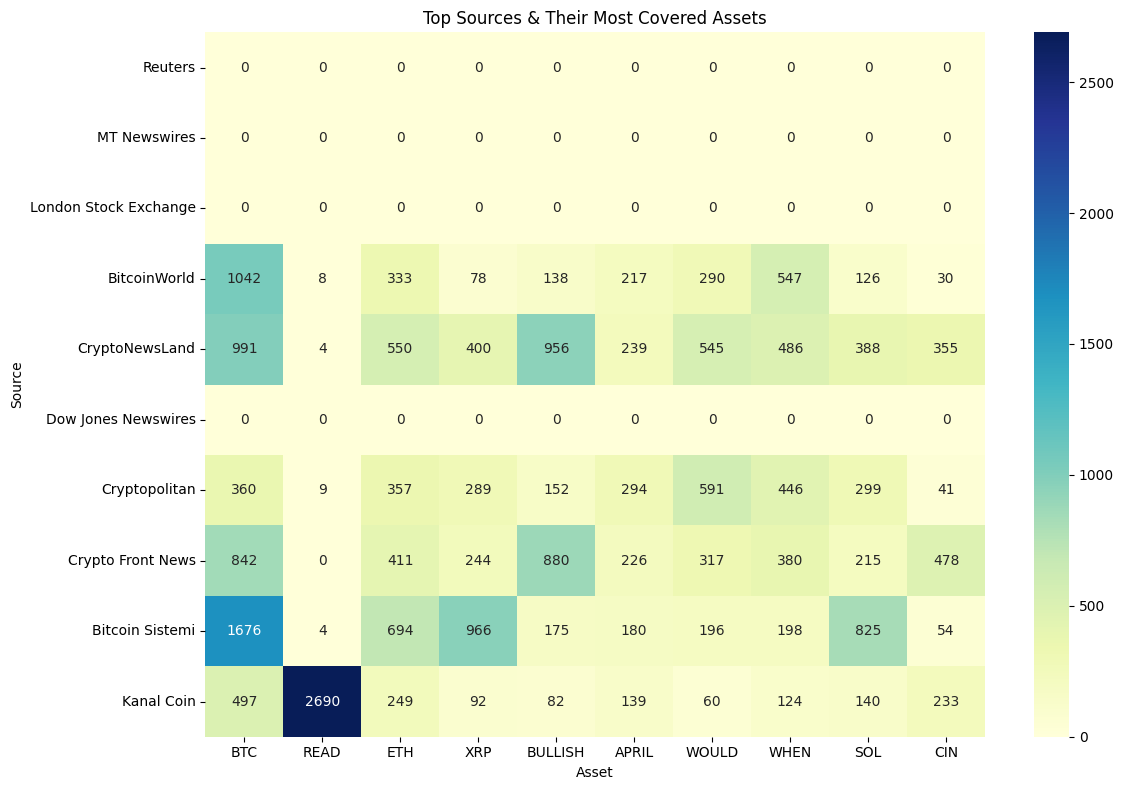

In [ ]:
# 1. Ensure pivot_table returns integers
heatmap_data = source_asset_df.pivot_table(
    index='Source',
    columns='Asset',
    values='Count',
    fill_value=0,
    aggfunc='sum'
).astype(int)

# 2. Plot with integer formatting
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data.loc[heatmap_data.sum(axis=1).nlargest(10).index,
                heatmap_data.sum(axis=0).nlargest(10).index],
    annot=True,
    fmt="d",  # Now safe to use integer formatting
    cmap="YlGnBu"
)
plt.title("Top Sources & Their Most Covered Assets")
plt.tight_layout()
plt.show()

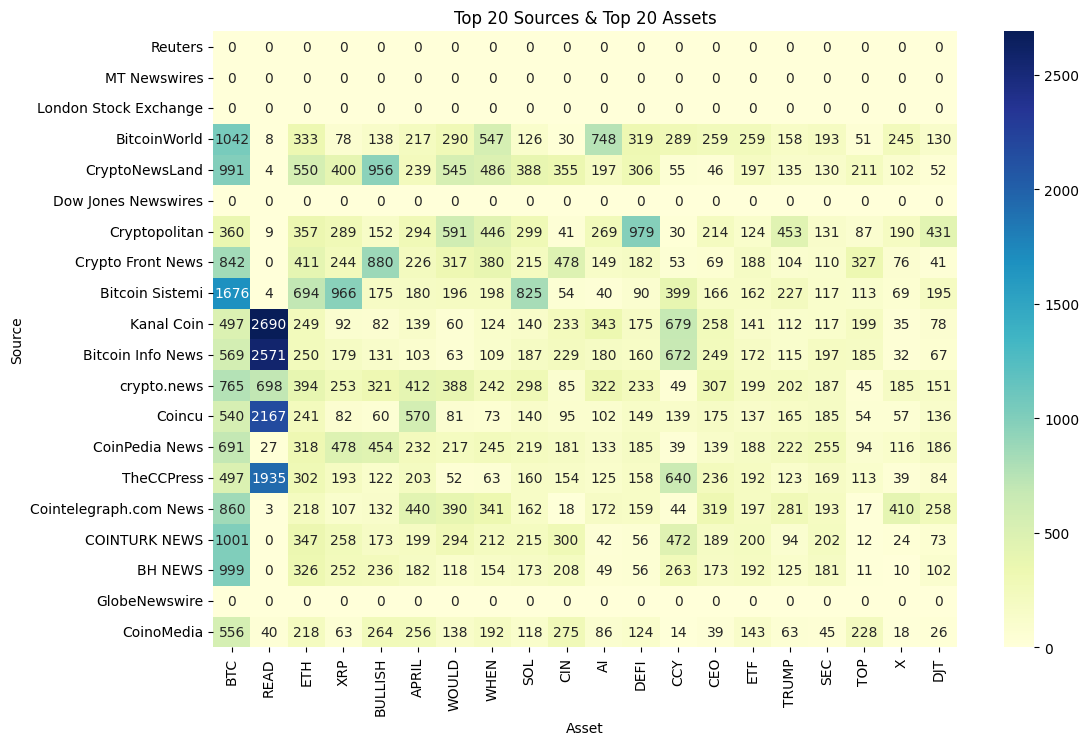

In [ ]:
top_n_sources = 20  # Adjust as needed
top_n_assets = 20   # Adjust as needed

filtered_data = heatmap_data.loc[
    heatmap_data.sum(axis=1).nlargest(top_n_sources).index,
    heatmap_data.sum(axis=0).nlargest(top_n_assets).index
]

plt.figure(figsize=(12, 8))
sns.heatmap(filtered_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title(f"Top {top_n_sources} Sources & Top {top_n_assets} Assets")
plt.show()

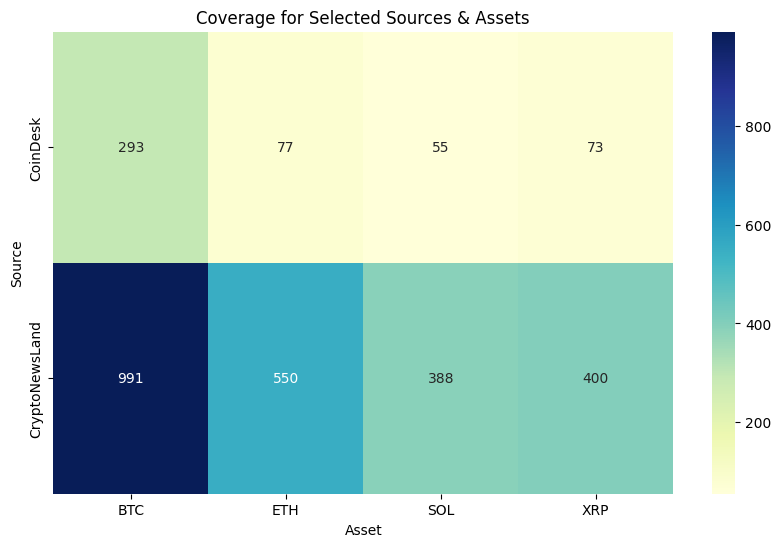

In [ ]:
selected_sources = ["CoinDesk", "CryptoNewsLand"]
selected_assets = ["BTC", "ETH", "SOL", "XRP"]

filtered_data = heatmap_data.loc[
    heatmap_data.index.intersection(selected_sources),
    heatmap_data.columns.intersection(selected_assets)
]

plt.figure(figsize=(10, 6))
sns.heatmap(filtered_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Coverage for Selected Sources & Assets")
plt.show()

In [ ]:
df_news['sourceName']

0            CryptoNewsLand
1         Crypto Front News
2             TheNewsCrypto
3            WalletInvestor
4            WalletInvestor
                ...        
241645          CoinLive.me
241646    Bitcoin Info News
241647       CoinPedia News
241648        COINTURK NEWS
241649      Bitcoin Sistemi
Name: sourceName, Length: 241650, dtype: object

# Reuter Assets !!!!

In [ ]:
df_news[df_news['sourceName'].str.lower() == 'reuters']

ID           releasedAt  \
1465    67c83ebde2bebd7aaabe2518  2025-02-26 05:17:10   
1496    67c83ebde2bebd7aaabe2517  2025-02-26 06:00:12   
1497    67c83ebde2bebd7aaabe2516  2025-02-26 06:00:26   
1690    67c83ebde2bebd7aaabe2511  2025-02-26 09:06:38   
2048    67c83ebde2bebd7aaabe2501  2025-02-26 15:04:58   
...                          ...                  ...   
241576  681f1c7516f7478622adbaa2  2025-05-10 09:24:01   
241581  681f1c7516f7478622adbaa1  2025-05-10 09:26:23   
241606  681f23aa3171460962341b36  2025-05-10 10:00:00   
241608  681f264025abcfe241c4ea78  2025-05-10 10:00:22   
241611  681f264025abcfe241c4ea77  2025-05-10 10:01:59   

                                                    title subtitle sourceName  \
1465    JPMorgan to convert $7 billion in mutual funds...      NaN    Reuters   
1496    NBSX: NGNGLD - GLD/NGNGLD: Additional Listing ...      NaN    Reuters   
1497    NBSX: SXN500 - Listing Of Additional SATRIX500...      NaN    Reuters   
1690    U.S. Bitcoin ETFs See Record Daily Outflow of ...      NaN    Reuters   
2048             US January single-family home sales data      NaN    Reuters   
...                                                   ...      ...        ...   
241576  Volkswagen Group Of America Inc. Is Recalling ...      NaN    Reuters   
241581  Volkswagen recalls over 89,000 US vehicles ove...      NaN    Reuters   
241606  Wellness companies eager to avoid WeightWatche...      NaN    Reuters   
241608  Sivers Semiconductors Renews Debt Financing wi...      NaN    Reuters   
241611  Sivers Semiconductors Renews Debt Financing Wi...      NaN    Reuters   

                                                sourceUrl             source  \
1465    https://tradingview.com/news/reuters.com,2025:...    tradingview-etf   
1496    https://tradingview.com/news/reuters.com,2025-...    tradingview-etf   
1497    https://tradingview.com/news/reuters.com,2025-...    tradingview-etf   
1690    https://tradingview.com/news/reuters.com,2025-...    tradingview-etf   
2048    https://tradingview.com/news/reuters.com,2025-...    tradingview-etf   
...                                                   ...                ...   
241576  https://tradingview.com/news/reuters.com,2025:...  tradingview-stock   
241581  https://tradingview.com/news/reuters.com,2025:...  tradingview-stock   
241606  https://tradingview.com/news/reuters.com,2025:...  tradingview-stock   
241608  https://tradingview.com/news/reuters.com,2025-...  tradingview-stock   
241611  https://tradingview.com/news/reuters.com,2025:...  tradingview-stock   

                                                 slug asset_names asset_slugs  \
1465          tag:reuters.com,2025:newsml_L3N3PH0CD:0         NaN         NaN   
1496    tag:reuters.com,2025-02-26:newsml_NbxZ0005a:0         NaN         NaN   
1497    tag:reuters.com,2025-02-26:newsml_NbxZ0011a:0         NaN         NaN   
1690    tag:reuters.com,2025-02-26:newsml_CDK4drJHP:0         NaN         NaN   
2048    tag:reuters.com,2025-02-26:newsml_AQN2K3KSX:0          ,           ,    
...                                               ...         ...         ...   
241576        tag:reuters.com,2025:newsml_AQN2KDM6F:0         NaN         NaN   
241581        tag:reuters.com,2025:newsml_L4N3RI04L:0         NaN         NaN   
241606        tag:reuters.com,2025:newsml_L1N3RG178:0      , , ,       , , ,    
241608   tag:reuters.com,2025-05-10:newsml_WkrT3G5h:0         NaN         NaN   
241611        tag:reuters.com,2025:newsml_FWN3RH56B:0         NaN         NaN   

                                       asset_symbols  \
1465                                        NYSE:JPM   
1496                                         JSE:GLD   
1497                                      JSE:STX500   
1690                                             NaN   
2048                            AMEX:XHB, NASDAQ:HGX   
...                                              ...   
241576                                      XE

#Number of Tokens

In [ ]:
# — 1) Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("Robertuus/Crypto_Sentiment_Analysis_Bert")

# — 2) Fill NaNs so everything is a string
for col in ['title', 'subtitle', 'content']:
    btc_news[col] = btc_news[col].fillna("")

# — 3) Helper to get token counts with progress bar
def token_length_series(texts, tokenizer, desc="Tokenizing"):
    lengths = []
    for txt in tqdm(texts, desc=desc):
        ids = tokenizer(txt, truncation=False, add_special_tokens=True)['input_ids']
        lengths.append(len(ids))
    return pd.Series(lengths)

# — 4) Compute stats for each field
stats = {}
percentiles = [0.25, 0.5, 0.75, 0.90, 0.95, 0.99]
for col in ['title', 'subtitle', 'content']:
    s = token_length_series(
        btc_news[col].tolist(),
        tokenizer,
        desc=f"Tokenizing {col}"
    )
    # describe with custom percentiles
    desc_stats = s.describe(percentiles=percentiles)
    stats[col] = desc_stats

# — 5) Build a DataFrame & clean up index names
token_stats_df = pd.DataFrame(stats).T
token_stats_df = token_stats_df.rename(index={
    '25%': 'Q1',
    '50%': 'median',
    '75%': 'Q3',
    '90%': 'P90',
    '95%': 'P95',
    '99%': 'P99',
})


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/348 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

NameError: name 'btc_news' is not defined

In [ ]:
token_stats_df

# FinBert Analysis

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load FinBERT model
model_name3 = "yiyanghkust/finbert-tone"
tokenizer3 = AutoTokenizer.from_pretrained(model_name3)
model3 = AutoModelForSequenceClassification.from_pretrained(model_name3)
model3.to(device)

def analyze_sentiment(texts):
    """
    Analyzes sentiment of a list of financial texts using FinBERT.
    Returns DataFrame with text and sentiment probabilities.
    """
    sentiments = []
    none_index = []
    for idx, text in enumerate(tqdm(texts, desc="Analyzing finance news"), start=0):
        if text is None:
            none_index.append(idx)
            continue
            sentiments.append({
                "text": None,
                "positive": None,
                "neutral": None,
                "negative": None,
                "raw_impact": None,
                "adjusted_impact": None})
        inputs = tokenizer3(text,
            return_tensors="pt",
            truncation=True,        # Important
            max_length=512,         # Limit input length
            padding=True).to(device)
        with torch.no_grad():
            outputs = model3(**inputs)
            probs = softmax(outputs.logits, dim=1).squeeze().cpu().numpy()

        positive, neutral, negative = probs
        raw_score = positive - negative
        adjusted_score = raw_score * (1 - neutral)

        sentiment = {
            "text": text,
            "positive": positive,
            "neutral": neutral,
            "negative": negative,
            "raw_impact": raw_score,
            "adjusted_impact": adjusted_score
        }
        sentiments.append(sentiment)
    return pd.DataFrame(sentiments), none_index

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
# 📰 Example crypto news (replace with actual news)
news = [
    "Bitcoin hits new all-time high as ETFs drive demand.",
    "Ethereum faces criticism over high gas fees.",
    "SEC delays decision on new crypto regulation.",
    "Solana network outage causes market concern."
]

In [ ]:
# Run sentiment analysis
results, _ = analyze_sentiment(news)
results

Analyzing finance news:   0%|          | 0/4 [00:00<?, ?it/s]

text      positive  \
0  Bitcoin hits new all-time high as ETFs drive d...  1.684132e-02   
1       Ethereum faces criticism over high gas fees.  3.563440e-06   
2      SEC delays decision on new crypto regulation.  4.781112e-05   
3       Solana network outage causes market concern.  2.570102e-07   

        neutral  negative  raw_impact  adjusted_impact  
0  9.807673e-01  0.002391    0.014450         0.000278  
1  8.498862e-07  0.999996   -0.999992        -0.999991  
2  8.115509e-06  0.999944   -0.999896        -0.999888  
3  1.069619e-06  0.999999   -0.999998        -0.999997

In [ ]:
# Load the fine-tuned crypto sentiment model
model_name2 = "Robertuus/Crypto_Sentiment_Analysis_Bert"
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)
model2 = AutoModelForSequenceClassification.from_pretrained(model_name2)
model2.to(device)

# Sentiment labels
labels = ['positive', 'negative']

# Sentiment analysis function
def analyze_crypto_news(news_list):
    results = []
    none_index = []
    for idx, text in enumerate(tqdm(news_list, desc="Analyzing Crypto news"), start=0):
        if text is None:
            none_index.append(idx)
            continue
            sentiments.append({
                "text": None,
                "positive": None,
                "neutral": None,
                "negative": None,
                "raw_impact": None,
                "adjusted_impact": None})
        inputs = tokenizer2(text, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model2(**inputs)
            probs = softmax(outputs.logits, dim=1).detach().cpu().numpy().flatten()

        sentiment = {
            "text": text,
            "positive": float(probs[0]),
            "negative": float(probs[1]),
            "predicted_label": labels[int(probs.argmax())],
            "impact": float(probs[0]) - float(probs[1])
        }
        results.append(sentiment)
    return pd.DataFrame(results), none_index

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
df, _ = analyze_crypto_news(news)
df

Analyzing Crypto news:   0%|          | 0/4 [00:00<?, ?it/s]

text  positive  negative  \
0  Bitcoin hits new all-time high as ETFs drive d...  0.996962  0.003038   
1       Ethereum faces criticism over high gas fees.  0.006473  0.993527   
2      SEC delays decision on new crypto regulation.  0.005402  0.994598   
3       Solana network outage causes market concern.  0.004619  0.995381   

  predicted_label    impact  
0        positive  0.993924  
1        negative -0.987055  
2        negative -0.989197  
3        negative -0.990762

In [ ]:
btc_news = df_news[df_news['asset_symbols'].str.contains(r'\bBTC\b', case=False, na=False)]
btc_news

ID           releasedAt  \
1       67bf0e677abefca47e66327e  2025-02-25 00:00:00   
5       67bf0e677abefca47e663282  2025-02-25 00:00:00   
22      67bf0e5b7abefca47e663270  2025-02-25 00:33:22   
24      67bf0e5b7abefca47e66326e  2025-02-25 00:35:51   
25      67bf0e5b7abefca47e66326d  2025-02-25 00:38:14   
...                          ...                  ...   
241636  681f2b652f35612ca7364559  2025-05-10 10:28:45   
241640  681f2df764fa9d1327a5ad34  2025-05-10 10:35:00   
241641  681f2df764fa9d1327a5ad33  2025-05-10 10:35:15   
241645  681f2df764fa9d1327a5ad2f  2025-05-10 10:38:58   
241648  681f2f61944b463d4d8a67f4  2025-05-10 10:42:16   

                                                    title  \
1       2025’s Crypto Battle: Altcoin vs. XRP and Bitc...   
5       Bitcoin Dives Below $90K Amid ETF Sell-Offs an...   
22      Montana Bitcoin reserve fund voted down, makin...   
24      Changpeng Zhao Shares His Crypto Portfolio: A ...   
25              What Does Zhao’s Crypto Portfolio Reveal?   
...                                                   ...   
241636     US VP Vance to Address Bitcoin 2025 Conference   
241640  Coinbase Reveals Cautious Approach, Avoids Bit...   
241641  Conor McGregor Advocates for Ireland's Bitcoin...   
241645  Bitcoin & Ethereum $3 Billion Options Set to E...   
241648  Steak ‘n Shake Embraces Bitcoin for Nationwide...   

                                                 subtitle         sourceName  \
1       Digital currencies now play a key role in glob...  Crypto Front News   
5       Bitcoin has dropped below $90,000 for the firs...     WalletInvestor   
22      A proposal in the Montana House of Representat...      Cryptopolitan   
24      Changpeng Zhao has shared his crypto portfolio...      COINTURK NEWS   
25      Changpeng Zhao, the prominent figure behind Bi...            BH NEWS   
...                                                   ...                ...   
241636  US VP JD Vance will speak at Bitcoin 2025, mar...         CoinLineup   
241640  Coinbase rejected a high-risk Bitcoin strategy...     CryptoNewsLand   
241641  Conor McGregor calls for Ireland Bitcoin reser...         TheCCPress   
241645  Bitcoin and Ethereum options worth $3 billion ...        CoinLive.me   
241648  Steak ‘n Shake will accept Bitcoin payments at...      COINTURK NEWS   

                                                sourceUrl         source  \
1       https://coinmarketcap.com/community/en/article...  coinmarketcap   
5       https://coinmarketcap.com/community/en/article...  coinmarketcap   
22      https://coinmarketcap.com/community/en/article...  coinmarketcap   
24      https://coinmarketcap.com/community/en/article...  coinmarketcap   
25      https://coinmarketcap.com/community/en/article...  coinmarketcap   
...                                                   ...            ...   
241636  https://coinmarketcap.com/community/en/article...  coinmarketcap   
241640  https://cryptonewsland.com/coinbase-reveals-ca...  coinmarketcap   
241641  https://coinmarketcap.com/community/en/article...  coinmarketcap   
241645  https://coinmarketcap.com/community/en/article...  coinmarketcap   
241648  https://coinmarketcap.com/community/en/article...  coinmarketcap   

                                                     slug  \
1       blockdag-vs-bitcoin-xrp-which-crypto-holds-lon...   
5       bitcoin-dives-below-90k-amid-etf-sell-offs-and...   
22      montana-bitcoin-reserve-fund-voted-down-making...   
24      changpeng-zhao-shares-his-crypto-portfolio-a-b...   
25                what-does-zhaos-crypto-portfolio-reveal   
...                                                   ...   
241636                   us-vp-vance-bitcoin-2025-address   
241640  coinbase-reveals-cautious-approach-avoids-bitc...   
241641             conor-mcgregor-ireland-bitcoin-reserve   
241645           bitcoin-ethereum-options-expire-may-2025   
241648  steak-n-shake-embraces-bitcoin-for-nationwide-...   

     

In [ ]:
list(btc_news['content'].head(2))

['Digital currencies now play a key role in global finance, with Bitcoin (BTC) and XRP at the forefront. Yet,BlockDAG (BDAG)is rising fast, challenging both with advanced technology and a fresh mining model. While XRP focuses on faster cross-border payments and Bitcoin remains a trusted digital asset, BlockDAG is reshaping mining through its X1 Miner and DAG-based structure, standing out as a forward-looking option.So, which cryptocurrency holds the most long-term potential? Let’s examine their strengths and future prospects.XRP: Leading Cross-Border Payments, But Can It Stay Ahead?XRP offers quick, low-cost cross-border payments, appealing to banks and financial services. With transactions completed in seconds for mere cents, XRP outperforms both Bitcoin and Ethereum in efficiency. Its widespread use has pushed its market cap beyond $130 billion, underscoring its impact on fintech.Despite its advantages, XRP faces growing competition. Traditional payment providers and newer blockchain

In [ ]:
analyze_sentiment(list(btc_news['content'].head(5)))

Analyzing finance news:   0%|          | 0/5 [00:00<?, ?it/s]

(                                                text  positive   neutral  \
 0  Digital currencies now play a key role in glob...  0.001199  0.998696   
 1  Bitcoin has dropped below $90,000 for the firs...  0.000056  0.000193   
 2  A proposal in the Montana House of Representat...  0.999905  0.000010   
 3  You can also read this news on COINTURK NEWS:C...  0.998131  0.001868   
 4  You can also read this news on BH NEWS:What Do...  0.449582  0.550388   
 
    negative  raw_impact  adjusted_impact  
 0  0.000105    0.001095         0.000001  
 1  0.999751   -0.999696        -0.999502  
 2  0.000085    0.999820         0.999810  
 3  0.000001    0.998130         0.996265  
 4  0.000030    0.449552         0.202124  ,
 [])

In [ ]:
analyze_sentiment(list(btc_news['title'].head(5)))

Analyzing finance news:   0%|          | 0/5 [00:00<?, ?it/s]

(                                                text  positive       neutral  \
 0  2025’s Crypto Battle: Altcoin vs. XRP and Bitc...  0.018167  9.809769e-01   
 1  Bitcoin Dives Below $90K Amid ETF Sell-Offs an...  0.009954  1.107147e-04   
 2  Montana Bitcoin reserve fund voted down, makin...  0.995119  2.095661e-05   
 3  Changpeng Zhao Shares His Crypto Portfolio: A ...  0.999891  1.060389e-04   
 4          What Does Zhao’s Crypto Portfolio Reveal?  0.999992  5.567996e-07   
 
    negative  raw_impact  adjusted_impact  
 0  0.000856    0.017311         0.000329  
 1  0.989935   -0.979982        -0.979873  
 2  0.004860    0.990259         0.990238  
 3  0.000003    0.999888         0.999782  
 4  0.000007    0.999985         0.999984  ,
 [])

In [ ]:
analyze_sentiment(list(btc_news['subtitle'].head(5)))

Analyzing finance news:   0%|          | 0/5 [00:00<?, ?it/s]

(                                                text  positive   neutral  \
 0  Digital currencies now play a key role in glob...  0.013389  0.986445   
 1  Bitcoin has dropped below $90,000 for the firs...  0.000004  0.000067   
 2  A proposal in the Montana House of Representat...  0.112080  0.000178   
 3  Changpeng Zhao has shared his crypto portfolio...  0.997914  0.002062   
 4  Changpeng Zhao, the prominent figure behind Bi...  0.999986  0.000010   
 
    negative  raw_impact  adjusted_impact  
 0  0.000167    0.013222         0.000179  
 1  0.999929   -0.999925        -0.999859  
 2  0.887742   -0.775662        -0.775524  
 3  0.000024    0.997889         0.995832  
 4  0.000004    0.999982         0.999972  ,
 [])

In [ ]:
# Apply to BTC news (assume df is already filtered as `btc_news`)
content_sent, none_content = analyze_sentiment(btc_news['content'].tolist())
title_sent, none_title = analyze_sentiment(btc_news['title'].tolist())
subtitle_sent, none_subtitle = analyze_sentiment(btc_news['subtitle'].fillna("").tolist())

# Rename columns for clarity
content_sent = content_sent.add_prefix("content_")
title_sent = title_sent.add_prefix("title_")
subtitle_sent = subtitle_sent.add_prefix("subtitle_")

# Combine all into one DataFrame
btc_sentiment = pd.concat([btc_news.reset_index(drop=True), content_sent, title_sent, subtitle_sent], axis=1)


Analyzing finance news:   0%|          | 0/18114 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Analyzing finance news:   0%|          | 0/18114 [00:00<?, ?it/s]

Analyzing finance news:   0%|          | 0/18114 [00:00<?, ?it/s]

In [ ]:
btc_sentiment

ID           releasedAt  \
0      67bf0e677abefca47e66327e  2025-02-25 00:00:00   
1      67bf0e677abefca47e663282  2025-02-25 00:00:00   
2      67bf0e5b7abefca47e663270  2025-02-25 00:33:22   
3      67bf0e5b7abefca47e66326e  2025-02-25 00:35:51   
4      67bf0e5b7abefca47e66326d  2025-02-25 00:38:14   
...                         ...                  ...   
18109  681f2b652f35612ca7364559  2025-05-10 10:28:45   
18110  681f2df764fa9d1327a5ad34  2025-05-10 10:35:00   
18111  681f2df764fa9d1327a5ad33  2025-05-10 10:35:15   
18112  681f2df764fa9d1327a5ad2f  2025-05-10 10:38:58   
18113  681f2f61944b463d4d8a67f4  2025-05-10 10:42:16   

                                                   title  \
0      2025’s Crypto Battle: Altcoin vs. XRP and Bitc...   
1      Bitcoin Dives Below $90K Amid ETF Sell-Offs an...   
2      Montana Bitcoin reserve fund voted down, makin...   
3      Changpeng Zhao Shares His Crypto Portfolio: A ...   
4              What Does Zhao’s Crypto Portfolio Reveal?   
...                                                  ...   
18109     US VP Vance to Address Bitcoin 2025 Conference   
18110  Coinbase Reveals Cautious Approach, Avoids Bit...   
18111  Conor McGregor Advocates for Ireland's Bitcoin...   
18112  Bitcoin & Ethereum $3 Billion Options Set to E...   
18113  Steak ‘n Shake Embraces Bitcoin for Nationwide...   

                                                subtitle         sourceName  \
0      Digital currencies now play a key role in glob...  Crypto Front News   
1      Bitcoin has dropped below $90,000 for the firs...     WalletInvestor   
2      A proposal in the Montana House of Representat...      Cryptopolitan   
3      Changpeng Zhao has shared his crypto portfolio...      COINTURK NEWS   
4      Changpeng Zhao, the prominent figure behind Bi...            BH NEWS   
...                                                  ...                ...   
18109  US VP JD Vance will speak at Bitcoin 2025, mar...         CoinLineup   
18110  Coinbase rejected a high-risk Bitcoin strategy...     CryptoNewsLand   
18111  Conor McGregor calls for Ireland Bitcoin reser...         TheCCPress   
18112  Bitcoin and Ethereum options worth $3 billion ...        CoinLive.me   
18113  Steak ‘n Shake will accept Bitcoin payments at...      COINTURK NEWS   

                                               sourceUrl         source  \
0      https://coinmarketcap.com/community/en/article...  coinmarketcap   
1      https://coinmarketcap.com/community/en/article...  coinmarketcap   
2      https://coinmarketcap.com/community/en/article...  coinmarketcap   
3      https://coinmarketcap.com/community/en/article...  coinmarketcap   
4      https://coinmarketcap.com/community/en/article...  coinmarketcap   
...                                                  ...            ...   
18109  https://coinmarketcap.com/community/en/article...  coinmarketcap   
18110  https://cryptonewsland.com/coinbase-reveals-ca...  coinmarketcap   
18111  https://coinmarketcap.com/community/en/article...  coinmarketcap   
18112  https://coinmarketcap.com/community/en/article...  coinmarketcap   
18113  https://coinmarketcap.com/community/en/article...  coinmarketcap   

                                                    slug  \
0      blockdag-vs-bitcoin-xrp-which-crypto-holds-lon...   
1      bitcoin-dives-below-90k-amid-etf-sell-offs-and...   
2      montana-bitcoin-reserve-fund-voted-down-making...   
3      changpeng-zhao-shares-his-crypto-portfolio-a-b...   
4                what-does-zhaos-crypto-portfolio-reveal   
...                                                  ...   
18109                   us-vp-vance-bitcoin-2025-address   
18110  coinbase-reveals-cautious-approach-avoids-bitc...   
18111             conor-mcgregor-ireland-bitcoin-reserve   
18112           bitcoin-ethereum-options-expire-may-2025   
18113  steak-n-shake-embraces-bitcoin-for-nationwide-...   

                                             asset_names  \
0   

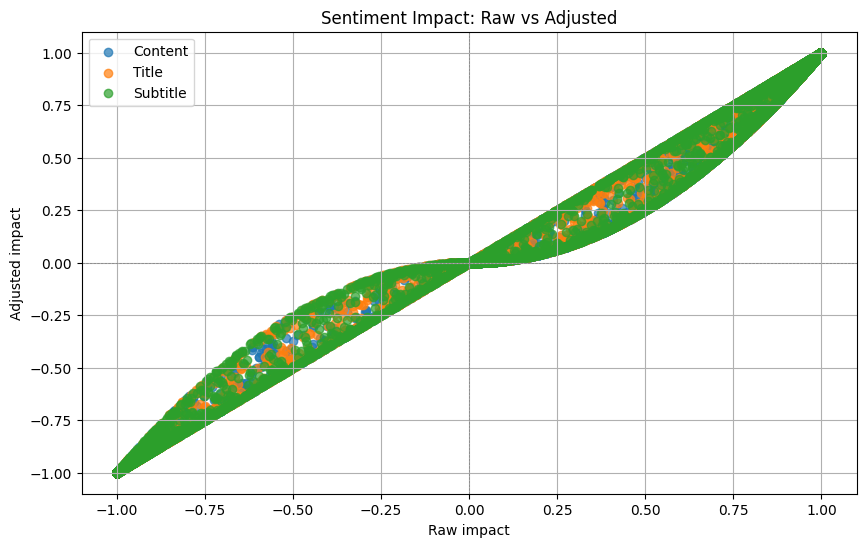

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(btc_sentiment['content_raw_impact'], btc_sentiment['content_adjusted_impact'], alpha=0.7, label='Content')
plt.scatter(btc_sentiment['title_raw_impact'], btc_sentiment['title_adjusted_impact'], alpha=0.7, label='Title')
plt.scatter(btc_sentiment['subtitle_raw_impact'], btc_sentiment['subtitle_adjusted_impact'], alpha=0.7, label='Subtitle')
plt.xlabel("Raw impact")
plt.ylabel("Adjusted impact")
plt.title("Sentiment Impact: Raw vs Adjusted")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-40-3c4a76dd0f0a>:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


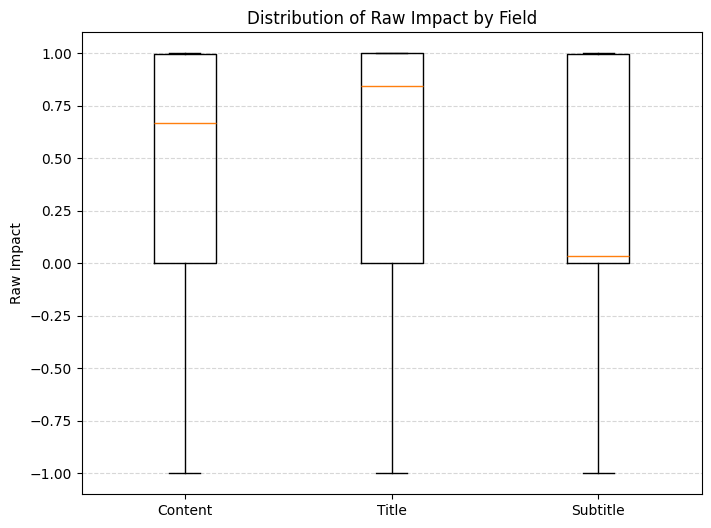

In [ ]:
# Prepare the data
data = [
    btc_sentiment['content_raw_impact'],
    btc_sentiment['title_raw_impact'],
    btc_sentiment['subtitle_raw_impact'],
]
labels = ['Content', 'Title', 'Subtitle']

# Draw
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=labels, showfliers=False)
plt.ylabel('Raw Impact')
plt.title('Distribution of Raw Impact by Field')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


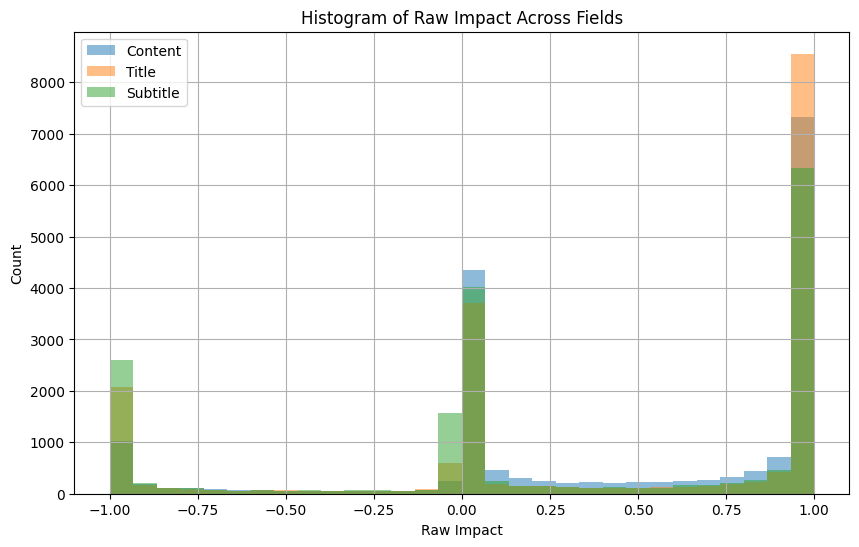

In [ ]:
plt.figure(figsize=(10, 6))
for col, label in [
    ('content_raw_impact', 'Content'),
    ('title_raw_impact',   'Title'),
    ('subtitle_raw_impact','Subtitle')
]:
    plt.hist(
        btc_sentiment[col],
        bins=30,
        alpha=0.5,
        label=label
    )

plt.xlabel('Raw Impact')
plt.ylabel('Count')
plt.title('Histogram of Raw Impact Across Fields')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def top_n_most_divergent(df: pd.DataFrame, cols, n: int = 10) -> pd.DataFrame:
    # Compute the range = max(raw impacts) − min(raw impacts)
    df = df.copy()
    df['impact_range'] = df[cols].max(axis=1) - df[cols].min(axis=1)

    # Sort descending by that range and take top n
    topn = df.sort_values('impact_range', ascending=False).head(n)

    # (Optional) select only the fields you care about
    return topn[['title', 'subtitle', 'content'] + cols + ['impact_range']]

In [ ]:
# Usage example:
top5 = top_n_most_divergent(btc_sentiment, ['content_raw_impact', 'title_raw_impact', 'subtitle_raw_impact'], n=5)
top5

title  \
6196   Bitcoin ATM Business Remained Sluggish Through...   
12418  Bitcoin, ETH, and XRP Price Prediction For Nex...   
10200  Bitcoin Price Reacts as US CPI for March Comes...   
2473   Cryptocurrency Prices on March 7: Bitcoin 4.76...   
3983   Crypto Price Analysis 3-14: BITCOIN: BTC, ETHE...   

                                                subtitle  \
6196   Bitcoin Depot has booked roughly $3 billion in...   
12418  The cryptocurrency market has concluded anothe...   
10200  BTC actually started to head south after the a...   
2473   The cryptocurrency market experienced a sharp ...   
3983   The crypto market had a mixed day as price act...   

                                                 content  content_raw_impact  \
6196   Bitcoin (BTC) may have surged above the $100,0...           -0.973377   
12418  The cryptocurrency market has concluded anothe...           -0.060437   
10200  The highly anticipated US Consumer Price Index...            0.931318   
2473   Cryptocurrency Prices on March 8 (IT Times)The...           -0.999501   
3983   The crypto market had a mixed day as price act...            0.811560   

       title_raw_impact  subtitle_raw_impact  impact_range  
6196          -0.999999             0.999999      1.999998  
12418          0.999999            -0.999998      1.999997  
10200         -0.999999             0.999998      1.999997  
2473           0.999996            -0.999996      1.999993  
3983           0.999999            -0.999993      1.999993

In [ ]:
print('title: ' + top5['title'][12418])
print('sub: ' + top5['subtitle'][12418])
print('content: ' + top5['content'][12418])

title: Bitcoin, ETH, and XRP Price Prediction For Next Week!
sub: The cryptocurrency market has concluded another week on a bearish note. With this, the top tokens continue to stumble around their important support levels. With a 24-hour trading volume of $43.61 billion, the cryptocurrency industry is currently worth $2.69 trillion. While the f...
content: The cryptocurrency market has concluded another week on a bearish note. With this, the top tokens continue to stumble around their important support levels. With a 24-hour trading volume of $43.61 billion, the cryptocurrency industry is currently worth $2.69 trillion. While the fear and greed index displays 32/100, the altcoin season still records 18/100, highlighting a delayed altcoin season.Notably, the Bitcoin price is back above the $85,000 mark, but continues to struggle around the price range. This hints at increased price volatility in the crypto market.On the other hand, the altcoin market is the worst affected as the top tok

In [ ]:
# Apply to BTC news (assume df is already filtered as `btc_news`)
content_sent, none_content = analyze_crypto_news(btc_news['content'].tolist())
title_sent, none_title = analyze_crypto_news(btc_news['title'].tolist())
subtitle_sent, none_subtitle = analyze_crypto_news(btc_news['subtitle'].fillna("").tolist())

# Rename columns for clarity
content_sent = content_sent.add_prefix("content_")
title_sent = title_sent.add_prefix("title_")
subtitle_sent = subtitle_sent.add_prefix("subtitle_")

# Combine all into one DataFrame
btc_crypto_sentiment = pd.concat([btc_news.reset_index(drop=True), content_sent, title_sent, subtitle_sent], axis=1)


Analyzing Crypto news:   0%|          | 0/18114 [00:00<?, ?it/s]

Analyzing Crypto news:   0%|          | 0/18114 [00:00<?, ?it/s]

Analyzing Crypto news:   0%|          | 0/18114 [00:00<?, ?it/s]

In [ ]:
btc_crypto_sentiment

In [ ]:
# Prepare the data
data = [
    btc_crypto_sentiment['content_impact'],
    btc_crypto_sentiment['title_impact'],
    btc_crypto_sentiment['subtitle_impact'],
]
labels = ['Content', 'Title', 'Subtitle']

# Draw
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=labels, showfliers=False)
plt.ylabel('Impact')
plt.title('Distribution of Impact by Field')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
for col, label in [
    ('content_impact', 'Content'),
    ('title_impact',   'Title'),
    ('subtitle_impact','Subtitle')
]:
    plt.hist(
        btc_crypto_sentiment[col],
        bins=30,
        alpha=0.5,
        label=label
    )

plt.xlabel('Impact')
plt.ylabel('Count')
plt.title('Histogram of Raw Impact Across Fields')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
top5 = top_n_most_divergent(btc_crypto_sentiment, ['content_impact', 'title_impact', 'subtitle_impact'], n=5)
top5

In [ ]:
print('title: ' + top5['title'][15566])
print('sub: ' + top5['subtitle'][15566])
print('content: ' + top5['content'][15566])

In [ ]:
analyze_crypto_news([top5['title'][5740] + top5['subtitle'][5740], top5['title'][15566] + top5['subtitle'][15566]])

# Use Scores for Prediction

In [ ]:
drive.mount('/content/drive')

# 2) Point to wherever you stored the pickle
path = '/content/drive/MyDrive/data_btc_1min.pickle'
df_ohlcv = pd.read_pickle(path)
df_ohlcv.head()

# Prediction Correlation and Test

In [ ]:
# 1) Compute the 1-minute close-to-close return on your OHLCV DF
ohlcv = df_ohlcv.copy()
ohlcv['dateTime'] = pd.to_datetime(ohlcv['dateTime'])
ohlcv = ohlcv.sort_values('dateTime')

# pct_change() by default computes (close_t - close_{t-1}) / close_{t-1}
ohlcv['return_close_1m'] = ohlcv['close'].pct_change()

# 2) Prepare your sentiment DF
sent = btc_sentiment.copy()
sent['releasedAt'] = pd.to_datetime(sent['releasedAt'])
sent = sent.sort_values('releasedAt')
sent = sent.rename(columns={'title_raw_impact':'impact'})  # or pick content_impact, etc.

# 3) Merge each news item to the next bar (within 1 min) and pull in return_close_1m
merged = pd.merge_asof(
    sent,
    ohlcv[['dateTime','return_close_1m']],
    left_on='releasedAt',
    right_on='dateTime',
    direction='forward',
    tolerance=pd.Timedelta('1min')
).dropna(subset=['return_close_1m'])

# 4) Quick diagnostics
print("Correlation impact ↔ close-to-close return:",
      merged['impact'].corr(merged['return_close_1m']))

# 5) directional accuracy
merged['pred_up'] = merged['impact'] > 0
merged['actual_up'] = merged['return_close_1m'] > 0

print("\nConfusion Matrix:")
print(confusion_matrix(merged['actual_up'], merged['pred_up']))

print("\nClassification Report:")
print(classification_report(merged['actual_up'], merged['pred_up']))


In [ ]:
merged

ID          releasedAt  \
0      67bf0e677abefca47e66327e 2025-02-25 00:00:00   
1      67bf0e677abefca47e663282 2025-02-25 00:00:00   
2      67bf0e5b7abefca47e663270 2025-02-25 00:33:22   
3      67bf0e5b7abefca47e66326e 2025-02-25 00:35:51   
4      67bf0e5b7abefca47e66326d 2025-02-25 00:38:14   
...                         ...                 ...   
18109  681f2b652f35612ca7364559 2025-05-10 10:28:45   
18110  681f2df764fa9d1327a5ad34 2025-05-10 10:35:00   
18111  681f2df764fa9d1327a5ad33 2025-05-10 10:35:15   
18112  681f2df764fa9d1327a5ad2f 2025-05-10 10:38:58   
18113  681f2f61944b463d4d8a67f4 2025-05-10 10:42:16   

                                                   title  \
0      2025’s Crypto Battle: Altcoin vs. XRP and Bitc...   
1      Bitcoin Dives Below $90K Amid ETF Sell-Offs an...   
2      Montana Bitcoin reserve fund voted down, makin...   
3      Changpeng Zhao Shares His Crypto Portfolio: A ...   
4              What Does Zhao’s Crypto Portfolio Reveal?   
...                                                  ...   
18109     US VP Vance to Address Bitcoin 2025 Conference   
18110  Coinbase Reveals Cautious Approach, Avoids Bit...   
18111  Conor McGregor Advocates for Ireland's Bitcoin...   
18112  Bitcoin & Ethereum $3 Billion Options Set to E...   
18113  Steak ‘n Shake Embraces Bitcoin for Nationwide...   

                                                subtitle         sourceName  \
0      Digital currencies now play a key role in glob...  Crypto Front News   
1      Bitcoin has dropped below $90,000 for the firs...     WalletInvestor   
2      A proposal in the Montana House of Representat...      Cryptopolitan   
3      Changpeng Zhao has shared his crypto portfolio...      COINTURK NEWS   
4      Changpeng Zhao, the prominent figure behind Bi...            BH NEWS   
...                                                  ...                ...   
18109  US VP JD Vance will speak at Bitcoin 2025, mar...         CoinLineup   
18110  Coinbase rejected a high-risk Bitcoin strategy...     CryptoNewsLand   
18111  Conor McGregor calls for Ireland Bitcoin reser...         TheCCPress   
18112  Bitcoin and Ethereum options worth $3 billion ...        CoinLive.me   
18113  Steak ‘n Shake will accept Bitcoin payments at...      COINTURK NEWS   

                                               sourceUrl         source  \
0      https://coinmarketcap.com/community/en/article...  coinmarketcap   
1      https://coinmarketcap.com/community/en/article...  coinmarketcap   
2      https://coinmarketcap.com/community/en/article...  coinmarketcap   
3      https://coinmarketcap.com/community/en/article...  coinmarketcap   
4      https://coinmarketcap.com/community/en/article...  coinmarketcap   
...                                                  ...            ...   
18109  https://coinmarketcap.com/community/en/article...  coinmarketcap   
18110  https://cryptonewsland.com/coinbase-reveals-ca...  coinmarketcap   
18111  https://coinmarketcap.com/community/en/article...  coinmarketcap   
18112  https://coinmarketcap.com/community/en/article...  coinmarketcap   
18113  https://coinmarketcap.com/community/en/article...  coinmarketcap   

                                                    slug  \
0      blockdag-vs-bitcoin-xrp-which-crypto-holds-lon...   
1      bitcoin-dives-below-90k-amid-etf-sell-offs-and...   
2      montana-bitcoin-reserve-fund-voted-down-making...   
3      changpeng-zhao-shares-his-crypto-portfolio-a-b...   
4                what-does-zhaos-crypto-portfolio-reveal   
...                                                  ...   
18109                   us-vp-vance-bitcoin-2025-address   
18110  coinbase-reveals-cautious-approach-avoids-bitc...   
18111             conor-mcgregor-ireland-bitcoin-reserve   
18112           bitcoin-ethereum-options-expire-may-2025   
18113  steak-n-shake-embraces-bitcoin-for-nationwide-...   

                                             asset_names  \
0               

In [ ]:
# — 1) Prepare your OHLCV DataFrame
ohlcv = df_ohlcv.copy()
ohlcv['dateTime'] = pd.to_datetime(ohlcv['dateTime'])
ohlcv = ohlcv.sort_values('dateTime')

# — 2) Compute close‐to‐close returns for each horizon
horizons = [1, 10, 60, 120, 60*24]  # minutes
for h in horizons:
    ohlcv[f'return_{h}m'] = ohlcv['close'].pct_change(periods=h)

# — 3) Prepare your sentiment DataFrame
sent = btc_crypto_sentiment.copy()
sent['releasedAt'] = pd.to_datetime(sent['releasedAt'])
sent = sent.sort_values('releasedAt')
# pick whichever impact you like (here: title_impact)
sent = sent.rename(columns={'subtitle_impact':'impact'})

# — 4) Merge sentiment → OHLCV (next bar, within 1 min)
merged = pd.merge_asof(
    sent,
    ohlcv[['dateTime'] + [f'return_{h}m' for h in horizons]],
    left_on='releasedAt',
    right_on='dateTime',
    direction='forward',
    tolerance=pd.Timedelta('1min')
).dropna(subset=[f'return_{h}m' for h in horizons])

# — 5) For each horizon, evaluate
for h in horizons:
    ret_col = f'return_{h}m'
    # binary prediction / actual
    merged[f'pred_up_{h}m']  = merged['impact'] > 0
    merged[f'act_up_{h}m']   = merged[ret_col] > 0

    print(f"\n=== Horizon: {h} min ===")
    # Confusion matrix
    cm = confusion_matrix(merged[f'act_up_{h}m'], merged[f'pred_up_{h}m'])
    print("Confusion Matrix:\n", cm)

    # Classification report
    cr = classification_report(
        merged[f'act_up_{h}m'],
        merged[f'pred_up_{h}m'],
        digits=4
    )
    print("Classification Report:\n", cr)


In [ ]:
merged

In [ ]:
def find_plot_most_accuracy_correlation(horizons, sentiment_df, df_ohlcv, impact_col_name, impact_name):
    # — 1) Prepare your OHLCV DF (reload if needed)
    ohlcv = df_ohlcv.copy()
    ohlcv['dateTime'] = pd.to_datetime(ohlcv['dateTime'])
    ohlcv = ohlcv.sort_values('dateTime')

    # Build a dict of Series, each one the forward return shifted by -h
    return_dict = {
        f'return_{h}m': ohlcv['close'].shift(-h) / ohlcv['close'] - 1
        for h in horizons
    }

    # Concatenate all at once—this avoids the fragmentation warning
    returns_df = pd.DataFrame(return_dict, index=ohlcv.index)
    ohlcv = pd.concat([ohlcv, returns_df], axis=1)

    # — 3) Prepare your sentiment DF
    sent = sentiment_df.copy()
    sent['releasedAt'] = pd.to_datetime(sent['releasedAt'])
    sent = sent.sort_values('releasedAt')
    # pick which impact you want to use (title/content/subtitle)
    sent = sent.rename(columns={impact_col_name: 'impact'})

    # — 4) Now loop to compute metrics (no more inserting into ohlcv)
    correlations = []
    accuracies   = []

    for h in tqdm(horizons, desc="Evaluating horizons"):
        ret_col = f'return_{h}m'

        merged = pd.merge_asof(
            sent,
            ohlcv[['dateTime', ret_col]],
            left_on='releasedAt',
            right_on='dateTime',
            direction='forward',
            tolerance=pd.Timedelta('1min')
        ).dropna(subset=[ret_col])

        # pearson correlation
        corr = merged['impact'].corr(merged[ret_col])
        correlations.append(corr)

        # classification accuracy
        actual_up = merged[ret_col] > 0
        pred_up   = merged['impact'] > 0
        accuracies.append(accuracy_score(actual_up, pred_up))

    # — 5) Build metrics DataFrame & plot
    metrics_df = pd.DataFrame({
        'horizon_min':   horizons,
        'horizon_hr':    horizons / 60,
        'correlation':   correlations,
        'accuracy':      accuracies
    })

    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()
    ax1.plot(metrics_df['horizon_hr'], metrics_df['correlation'], label='Correlation', linewidth=2)
    ax2.plot(metrics_df['horizon_hr'], metrics_df['accuracy'],   label='Accuracy',   linestyle='--', linewidth=2)
    ax1.set_xlabel('Horizon (hours)')
    ax1.set_ylabel('Pearson Correlation')
    ax2.set_ylabel('Classification Accuracy')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True)
    plt.title("Sentiment Impact of " + impact_name + " vs. Future Returns Over Horizons")
    plt.show()

    # — 6) Print best-performing horizons
    best_corr = metrics_df.loc[metrics_df['correlation'].idxmax()]
    best_acc  = metrics_df.loc[metrics_df['accuracy'].idxmax()]

    print(f"Highest correlation at {int(best_corr['horizon_min'])} min ({best_corr['horizon_hr']:.1f} h): {best_corr['correlation']:.4f}")
    print(f"Highest accuracy    at {int(best_acc['horizon_min'])} min ({best_acc['horizon_hr']:.1f} h): {best_acc['accuracy']:.4f}")


In [ ]:
horizons = np.arange(10, 10000, 10)

# FinBert Model Prediction Test

In [ ]:
find_plot_most_accuracy_correlation(horizons, btc_sentiment, df_ohlcv, "title_raw_impact", "title")

In [ ]:
find_plot_most_accuracy_correlation(horizons, btc_sentiment, df_ohlcv, "subtitle_raw_impact", "subtitle")

In [ ]:
find_plot_most_accuracy_correlation(horizons, btc_sentiment, df_ohlcv, "content_raw_impact", "content")

# Crypto Bert Model Prediction Test

Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

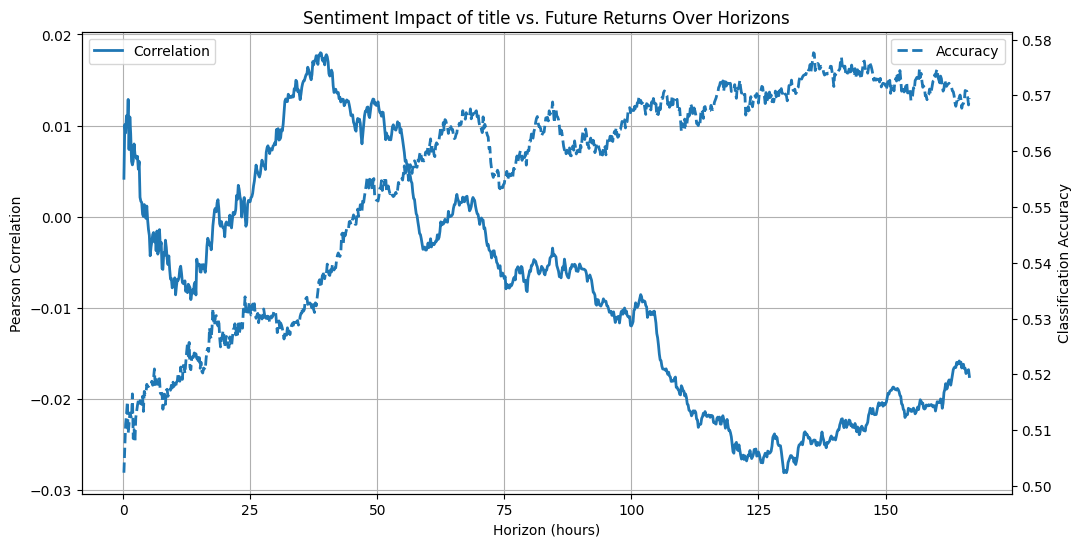

Highest correlation at 2330 min (38.8 h): 0.0180
Highest accuracy    at 8150 min (135.8 h): 0.5776


In [ ]:
find_plot_most_accuracy_correlation(horizons, btc_crypto_sentiment, df_ohlcv, "title_impact" , "title")

In [ ]:
find_plot_most_accuracy_correlation(horizons, btc_crypto_sentiment, df_ohlcv, "subtitle_impact", "subtitle")

In [ ]:
find_plot_most_accuracy_correlation(horizons, btc_crypto_sentiment, df_ohlcv, "content_impact", "content")

In [ ]:
btc_crypto_sentiment['source'].unique()

In [ ]:
top20_sources = btc_crypto_sentiment['sourceName'] \
    .value_counts() \
    .head(20) \
    .index \
    .tolist()

top20_sources

In [ ]:
len(btc_crypto_sentiment)

In [ ]:
for source in top20_sources:
    print(source + " bitcoin news count: " + str(len(btc_crypto_sentiment[btc_crypto_sentiment['sourceName'] == source])))

Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

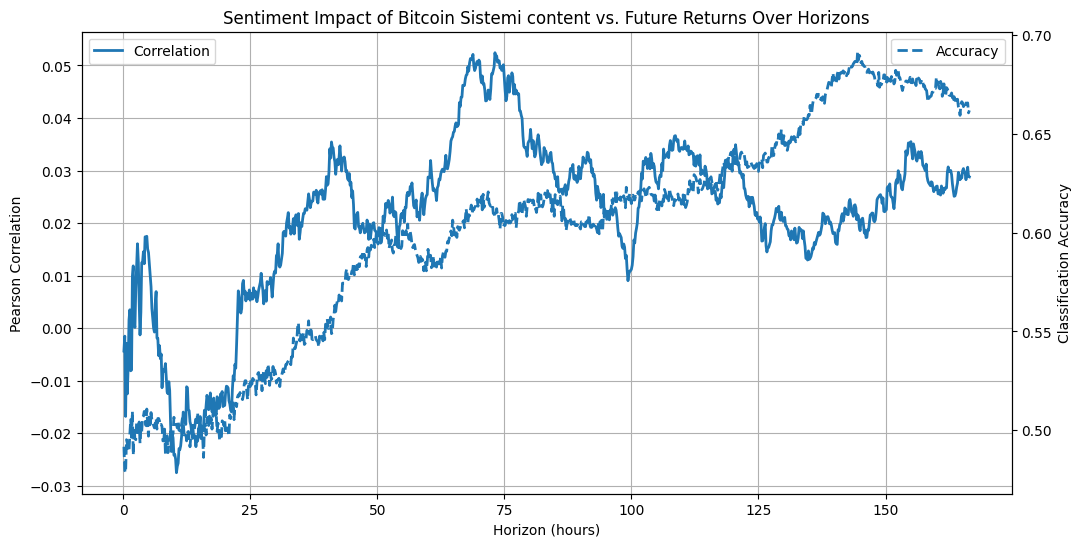

Highest correlation at 4390 min (73.2 h): 0.0524
Highest accuracy    at 8670 min (144.5 h): 0.6910


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

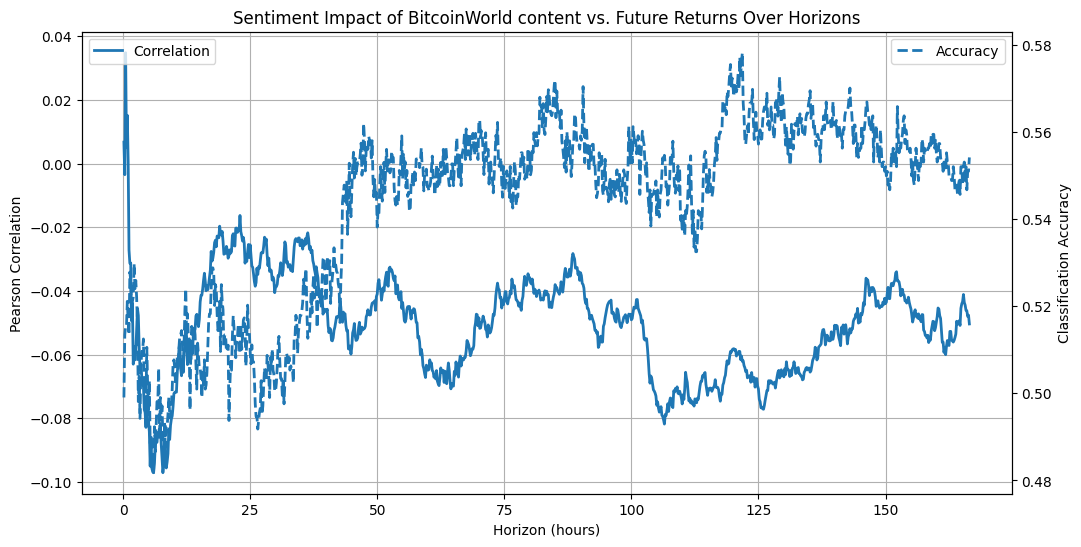

Highest correlation at 30 min (0.5 h): 0.0348
Highest accuracy    at 7310 min (121.8 h): 0.5782


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

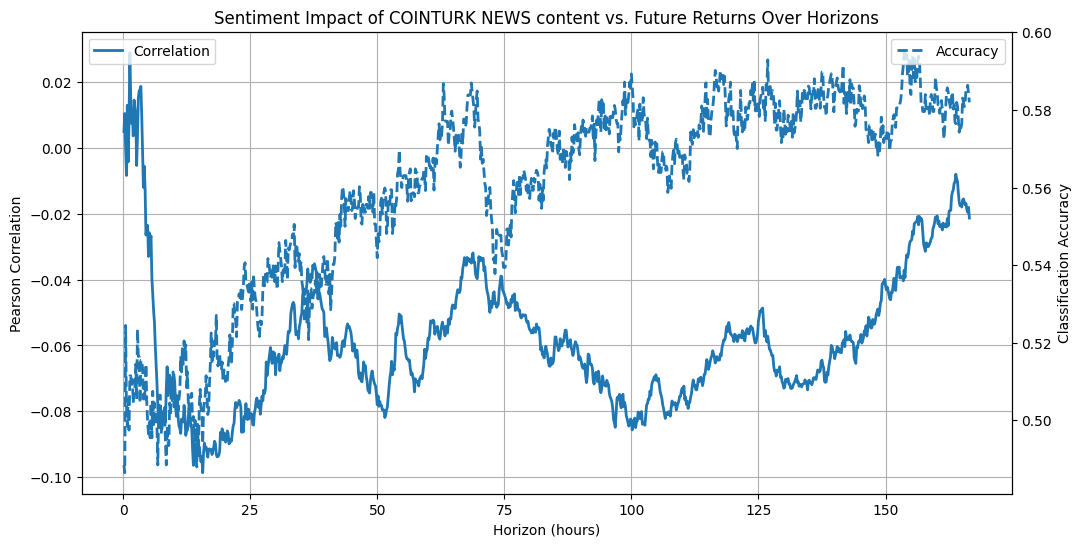

Highest correlation at 80 min (1.3 h): 0.0290
Highest accuracy    at 9220 min (153.7 h): 0.5947


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

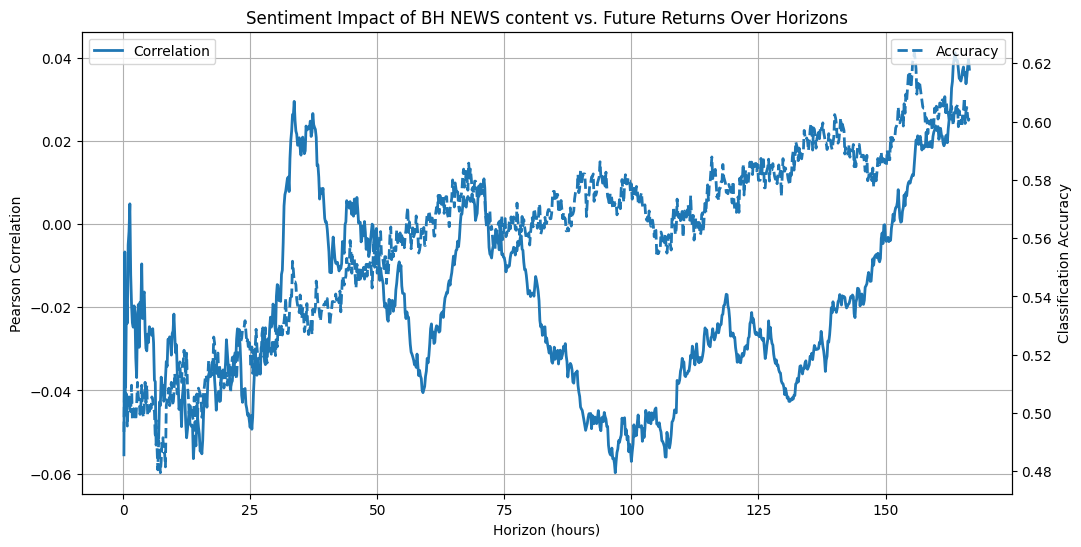

Highest correlation at 9820 min (163.7 h): 0.0412
Highest accuracy    at 9340 min (155.7 h): 0.6236


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

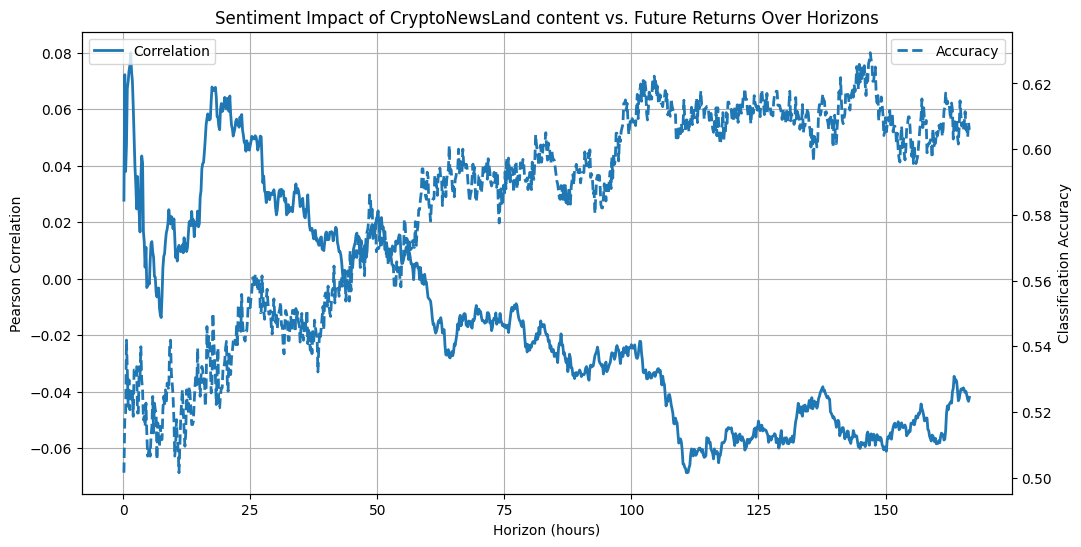

Highest correlation at 90 min (1.5 h): 0.0801
Highest accuracy    at 8820 min (147.0 h): 0.6293


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

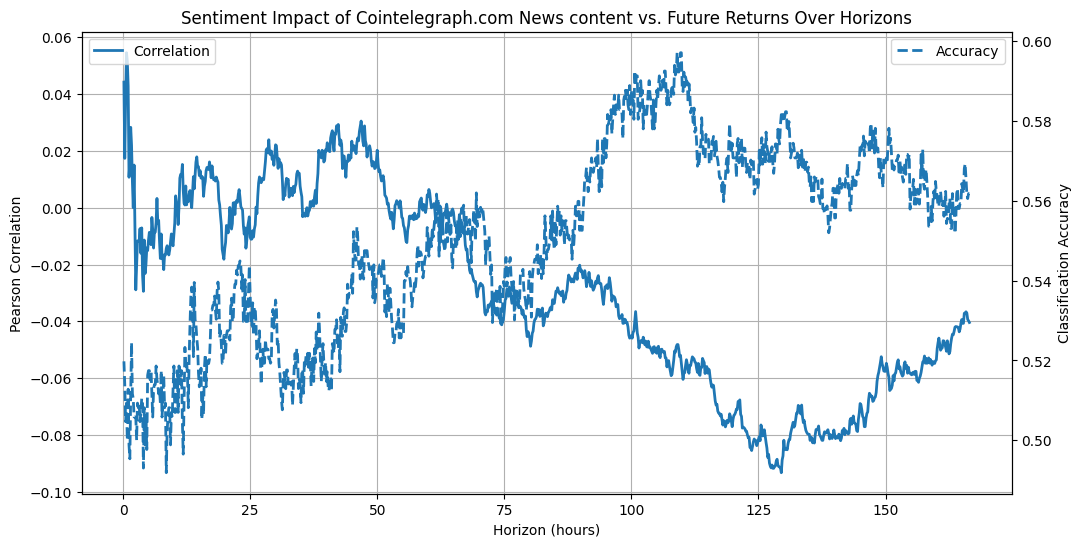

Highest correlation at 40 min (0.7 h): 0.0545
Highest accuracy    at 6540 min (109.0 h): 0.5971


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

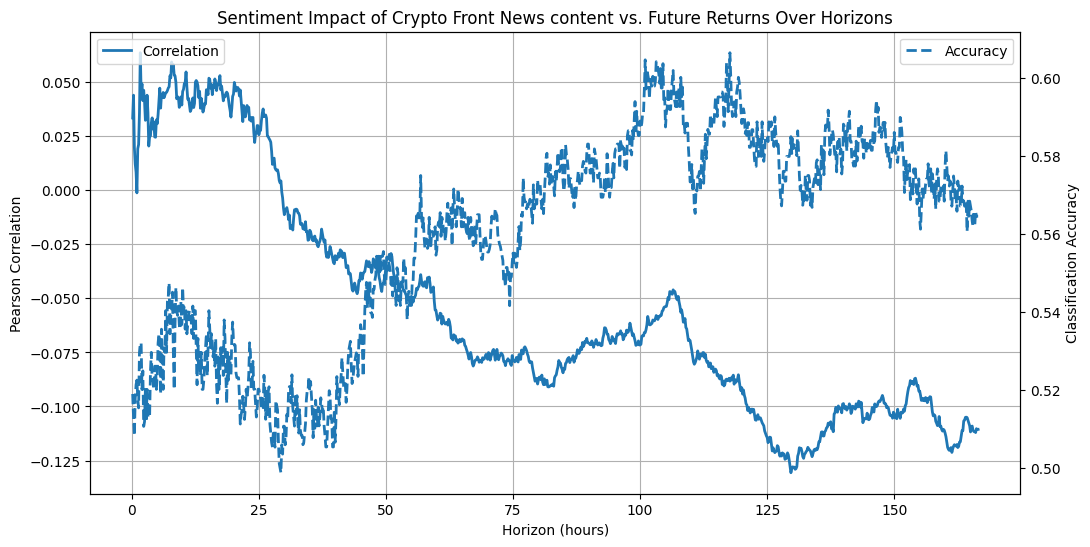

Highest correlation at 100 min (1.7 h): 0.0636
Highest accuracy    at 7060 min (117.7 h): 0.6066


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

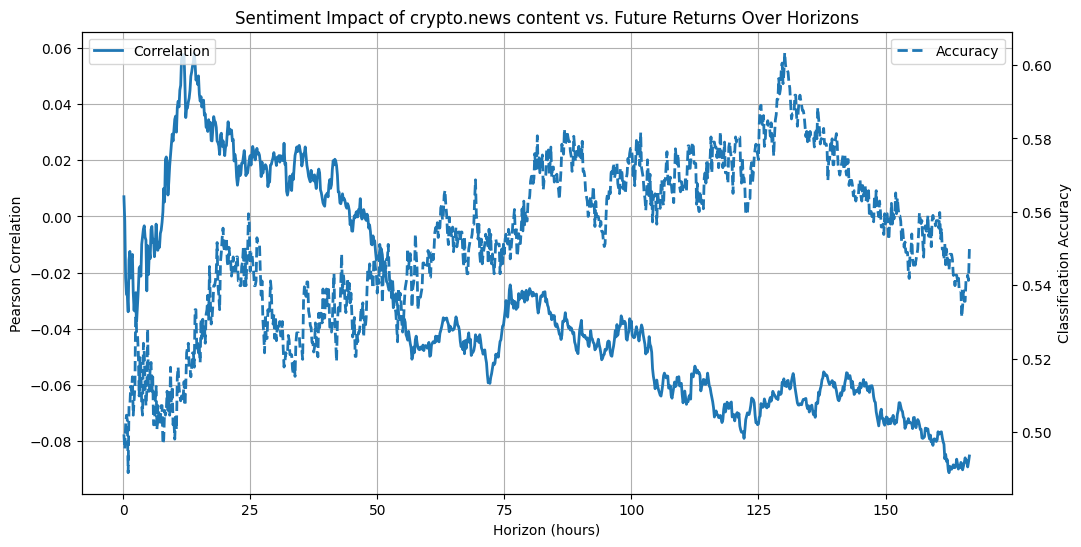

Highest correlation at 840 min (14.0 h): 0.0584
Highest accuracy    at 7810 min (130.2 h): 0.6034


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

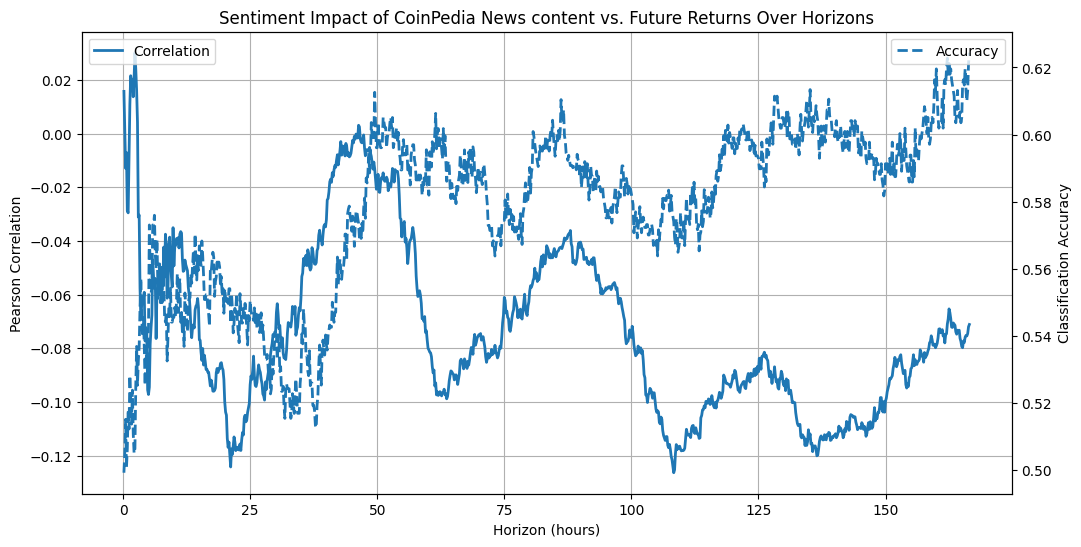

Highest correlation at 140 min (2.3 h): 0.0301
Highest accuracy    at 9990 min (166.5 h): 0.6244


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

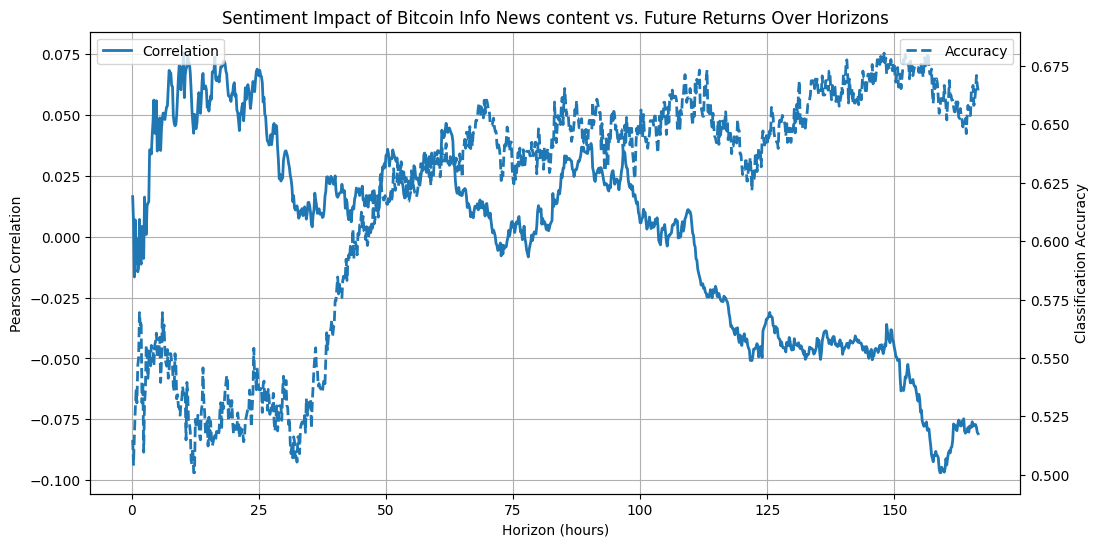

Highest correlation at 610 min (10.2 h): 0.0756
Highest accuracy    at 9400 min (156.7 h): 0.6807


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

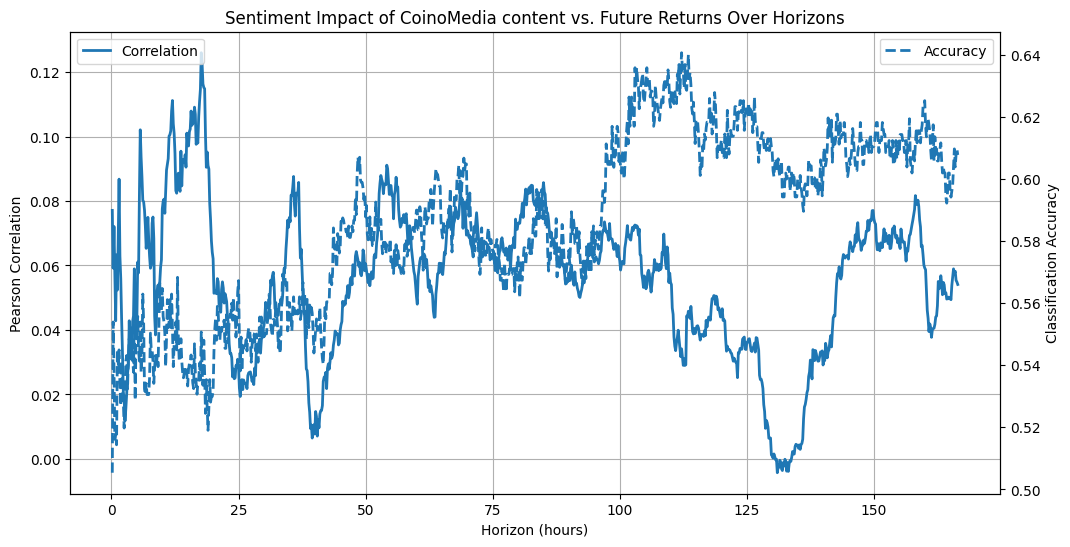

Highest correlation at 1060 min (17.7 h): 0.1260
Highest accuracy    at 6730 min (112.2 h): 0.6407


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

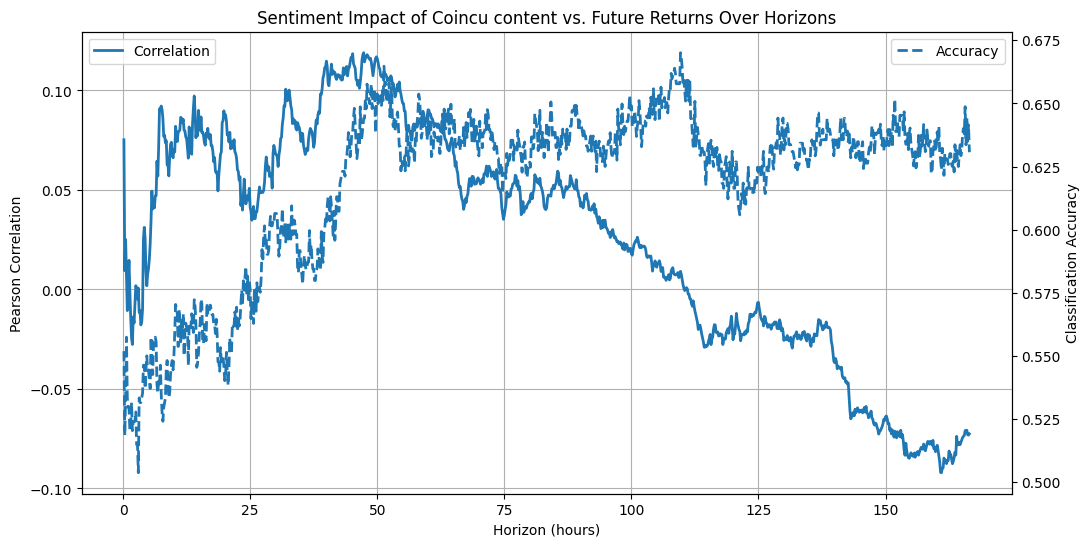

Highest correlation at 2840 min (47.3 h): 0.1190
Highest accuracy    at 6580 min (109.7 h): 0.6701


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

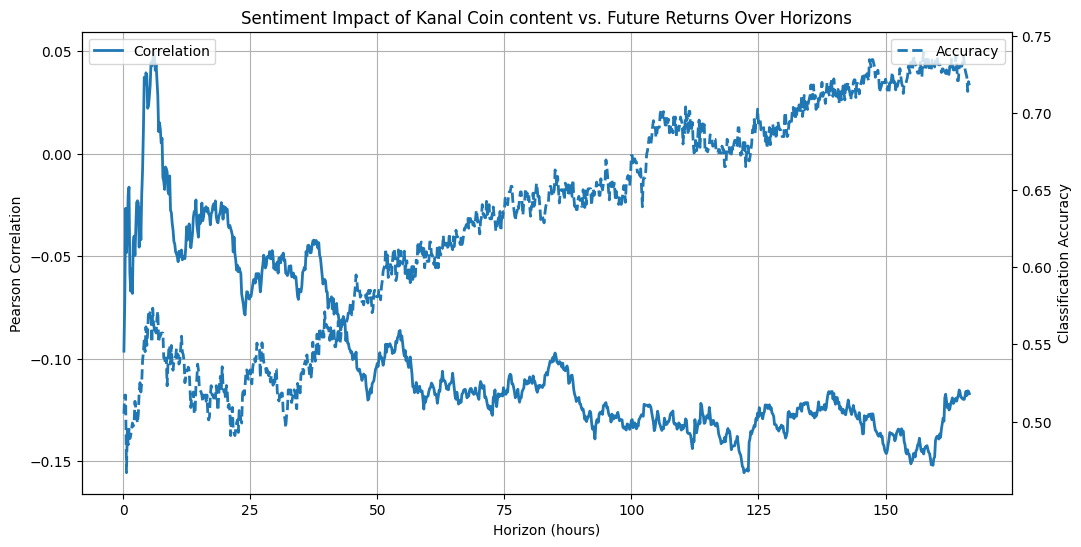

Highest correlation at 360 min (6.0 h): 0.0493
Highest accuracy    at 9450 min (157.5 h): 0.7390


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

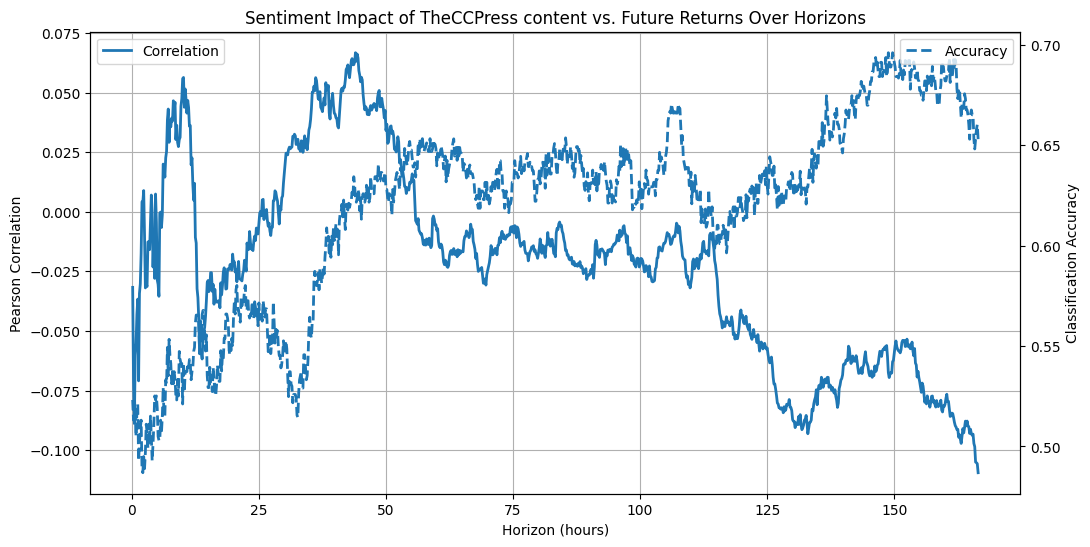

Highest correlation at 2640 min (44.0 h): 0.0667
Highest accuracy    at 8930 min (148.8 h): 0.6960


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

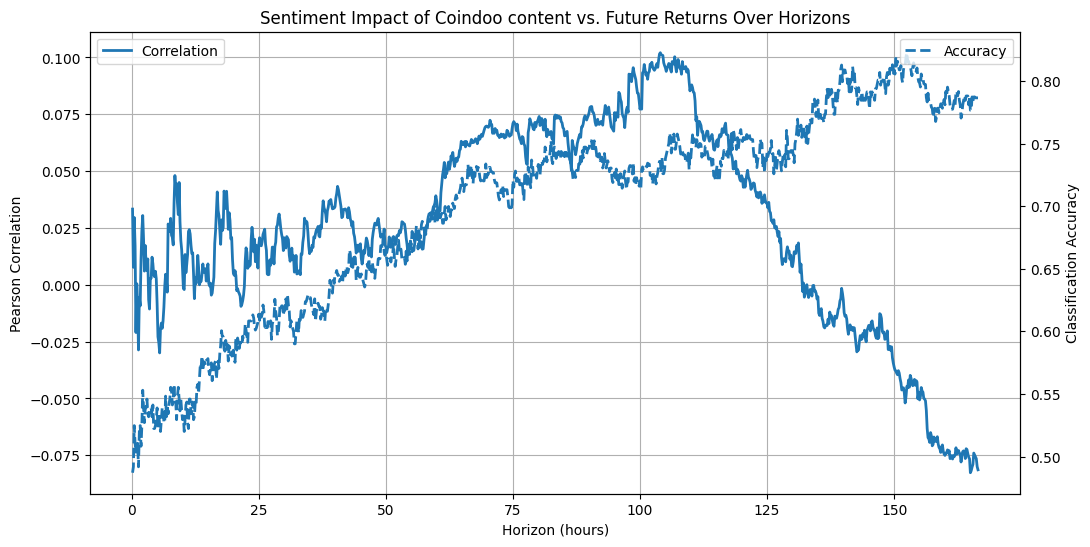

Highest correlation at 6240 min (104.0 h): 0.1021
Highest accuracy    at 9150 min (152.5 h): 0.8225


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

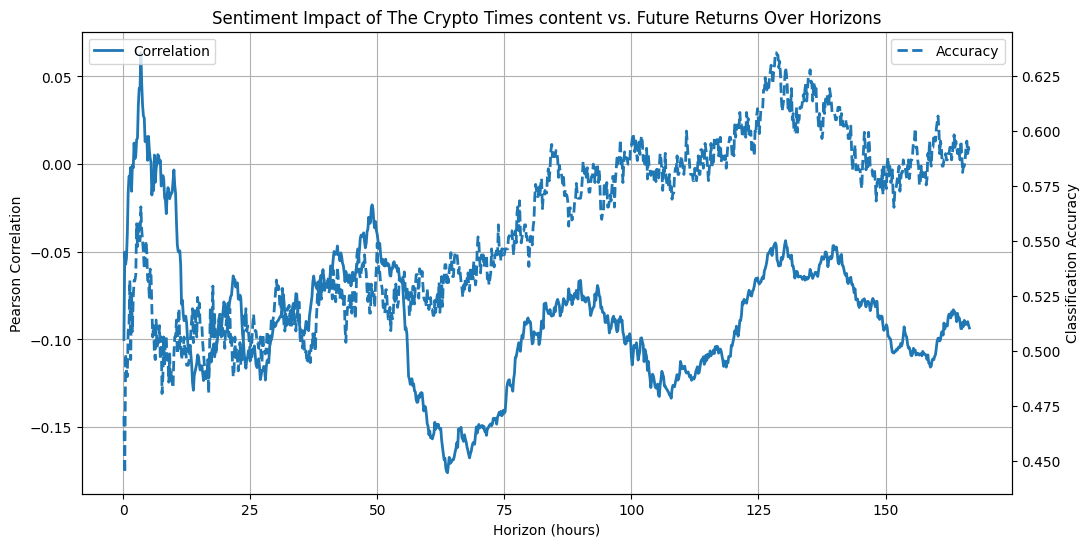

Highest correlation at 210 min (3.5 h): 0.0635
Highest accuracy    at 7700 min (128.3 h): 0.6356


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

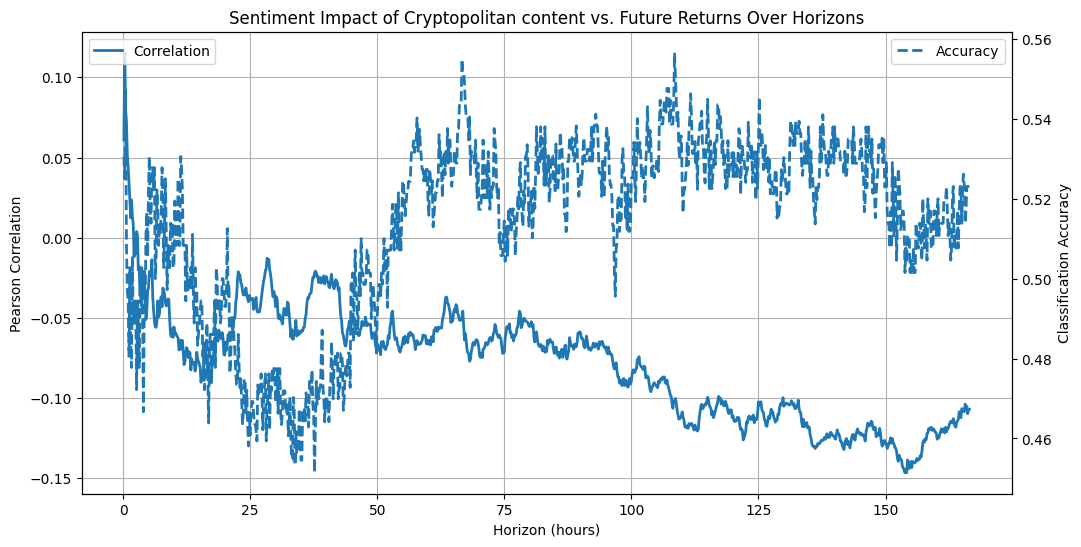

Highest correlation at 20 min (0.3 h): 0.1153
Highest accuracy    at 6510 min (108.5 h): 0.5565


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

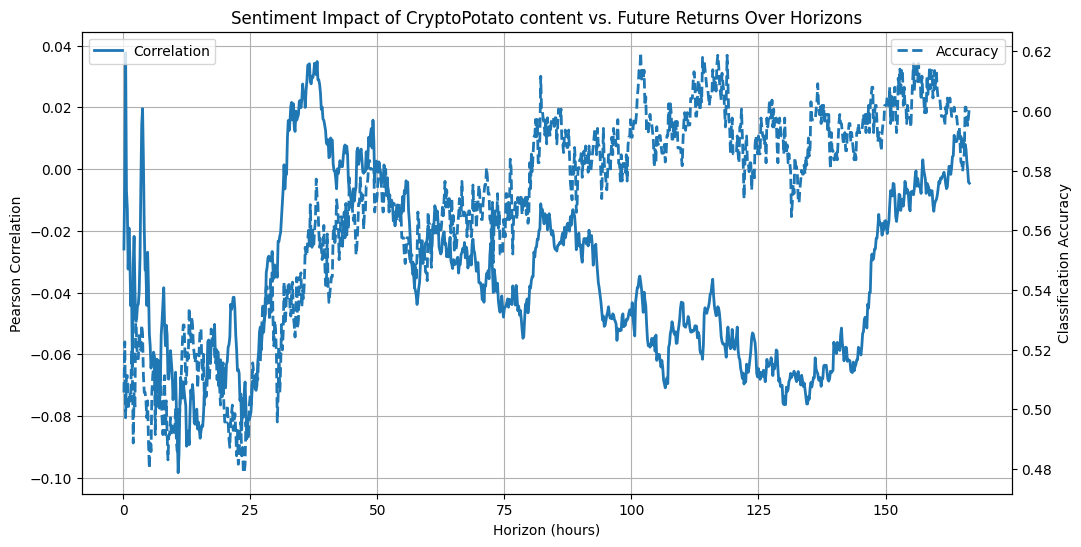

Highest correlation at 30 min (0.5 h): 0.0377
Highest accuracy    at 6110 min (101.8 h): 0.6195


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

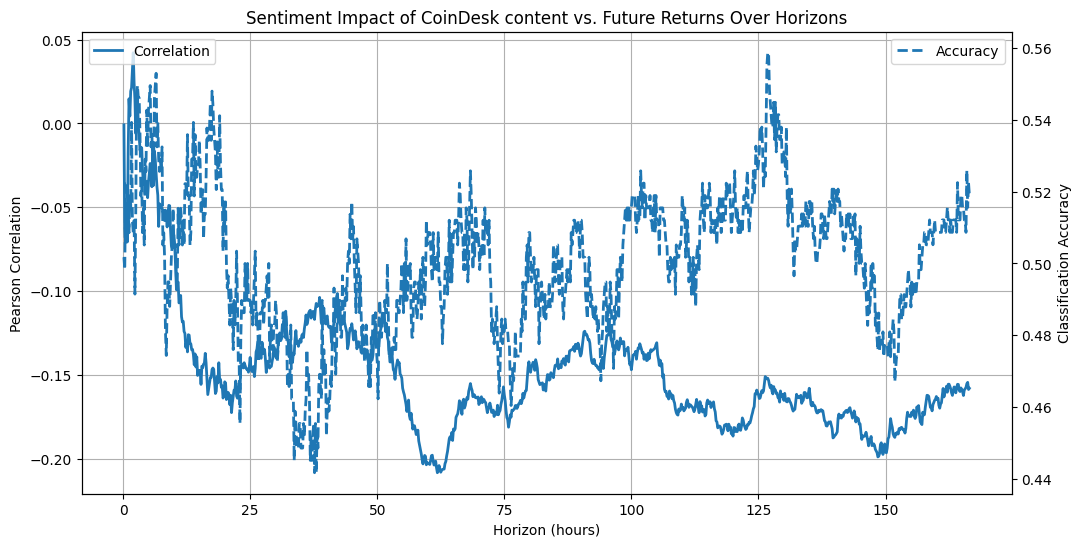

Highest correlation at 120 min (2.0 h): 0.0422
Highest accuracy    at 7610 min (126.8 h): 0.5586


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

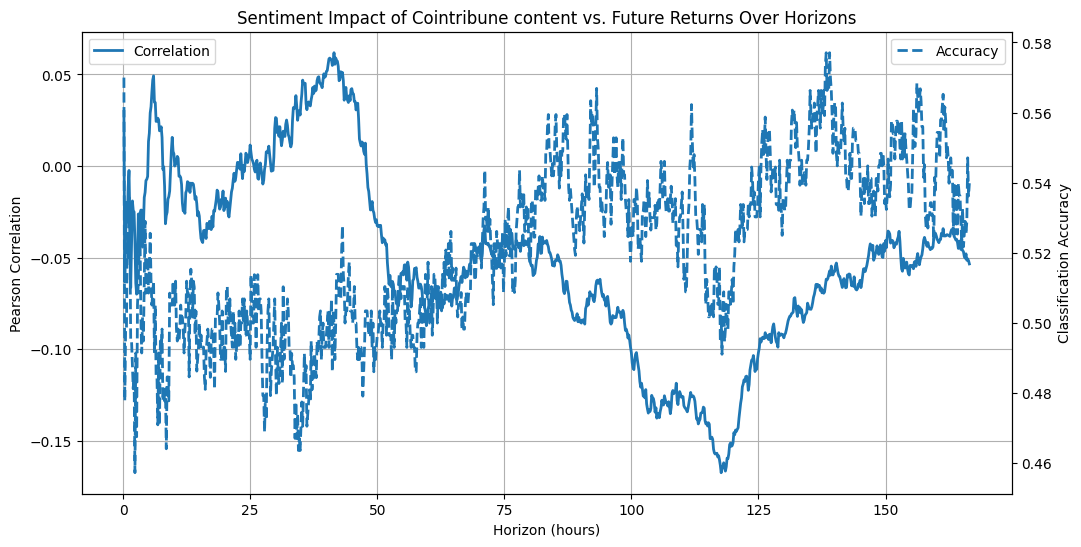

Highest correlation at 2490 min (41.5 h): 0.0618
Highest accuracy    at 8300 min (138.3 h): 0.5771


In [ ]:
for source in top20_sources:
    find_plot_most_accuracy_correlation(
        horizons,
        btc_crypto_sentiment[btc_crypto_sentiment['sourceName'] == source],
        df_ohlcv,
        "content_impact",
        source + " content")

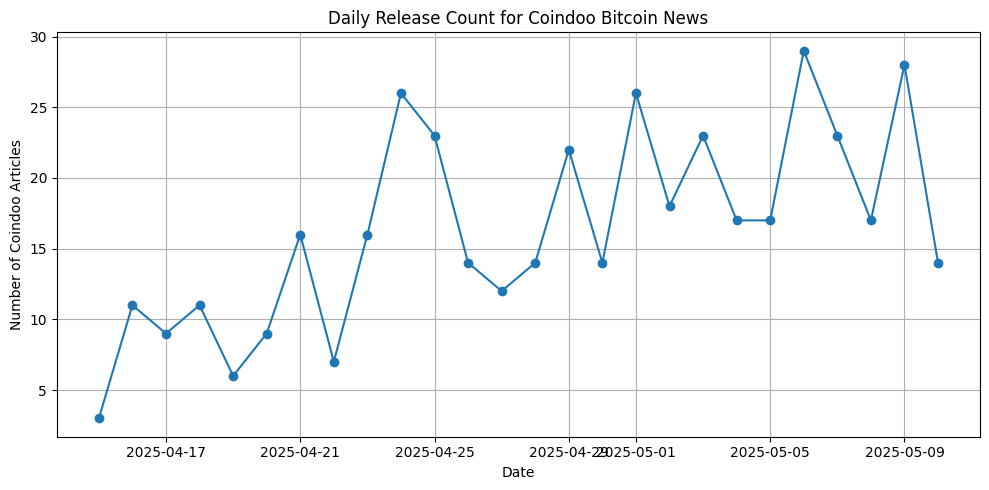

In [ ]:
# 1) Ensure releasedAt is datetime
btc_crypto_sentiment['releasedAt'] = pd.to_datetime(btc_crypto_sentiment['releasedAt'])

# 2) Filter for Coindoo
df_coindoo = btc_crypto_sentiment[
    btc_crypto_sentiment['sourceName'].str.contains('Coindoo', case=False)
].copy()

# 3) Aggregate counts by day (change freq='H' for hourly, or 'T' for minute-level)
daily_counts = (
    df_coindoo
    .set_index('releasedAt')
    .groupby(pd.Grouper(freq='D'))
    .size()
)

# 4) Plot
plt.figure(figsize=(10, 5))
plt.plot(daily_counts.index, daily_counts.values, marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Coindoo Articles')
plt.title('Daily Release Count for Coindoo Bitcoin News')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def aggregate_sentiment_per_minute(sentiment_df, time_col, impact_col):
    """
    Groups sentiment_df by each minute (flooring timestamps) and
    returns a new DataFrame with:
      - minute: the floored datetime (to minute)
      - impact: the average impact of all items in that minute
    """
    df = sentiment_df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    # floor to the minute
    df['minute'] = df[time_col].dt.floor('min')
    # group and average
    agg = (
        df
        .groupby('minute')[impact_col]
        .mean()
        .reset_index()
        .rename(columns={'minute':'releasedAt', impact_col:'impact'})
    )
    return agg

def find_plot_metrics_by_minute(horizons, sentiment_df, df_ohlcv, impact_col_name, impact_name):
    # 1) Pre-aggregate sentiment into minute buckets
    sent_agg = aggregate_sentiment_per_minute(sentiment_df, time_col='releasedAt', impact_col=impact_col_name)
    sent_agg = sent_agg.sort_values('releasedAt')

    # 2) Prepare OHLCV
    ohlcv = df_ohlcv.copy()
    ohlcv['dateTime'] = pd.to_datetime(ohlcv['dateTime'])
    ohlcv = ohlcv.sort_values('dateTime')

    # 3) Compute all shifted returns at once (avoid fragmentation)
    return_dict = {
        f'return_{h}m': ohlcv['close'].shift(-h) / ohlcv['close'] - 1
        for h in horizons
    }
    returns_df = pd.DataFrame(return_dict, index=ohlcv.index)
    ohlcv = pd.concat([ohlcv, returns_df], axis=1)

    # 4) Loop to compute per-horizon metrics
    correlations = []
    accuracies   = []

    for h in tqdm(horizons, desc="Evaluating horizons"):
        ret_col = f'return_{h}m'

        # merge-on minute-to-minute basis
        merged = pd.merge_asof(
            sent_agg,
            ohlcv[['dateTime', ret_col]],
            left_on='releasedAt',
            right_on='dateTime',
            direction='forward',
            tolerance=pd.Timedelta('1min')
        ).dropna(subset=[ret_col])

        correlations.append( merged['impact'].corr(merged[ret_col]) )
        actual_up = merged[ret_col] > 0
        pred_up   = merged['impact'] > 0
        accuracies.append( accuracy_score(actual_up, pred_up) )

    # 5) Build metrics DataFrame & plot
    metrics_df = pd.DataFrame({
        'horizon_min': horizons,
        'horizon_hr':  horizons / 60,
        'correlation': correlations,
        'accuracy':    accuracies
    })

    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()
    ax1.plot(metrics_df['horizon_hr'], metrics_df['correlation'], label='Correlation', linewidth=2)
    ax2.plot(metrics_df['horizon_hr'], metrics_df['accuracy'],   label='Accuracy',   linestyle='--', linewidth=2)

    ax1.set_xlabel('Horizon (hours)')
    ax1.set_ylabel('Pearson Correlation')
    ax2.set_ylabel('Classification Accuracy')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True)
    plt.title(f"Avg {impact_name} Impact vs. Future Returns Over Horizons")
    plt.show()

    # 6) Print best-performing horizons
    best_corr = metrics_df.loc[metrics_df['correlation'].idxmax()]
    best_acc  = metrics_df.loc[metrics_df['accuracy'].idxmax()]

    print(f"▶ Highest correlation at {int(best_corr['horizon_min'])} min "
          f"({best_corr['horizon_hr']:.1f} h): {best_corr['correlation']:.4f}")
    print(f"▶ Highest accuracy    at {int(best_acc['horizon_min'])} min "
          f"({best_acc['horizon_hr']:.1f} h): {best_acc['accuracy']:.4f}")

Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

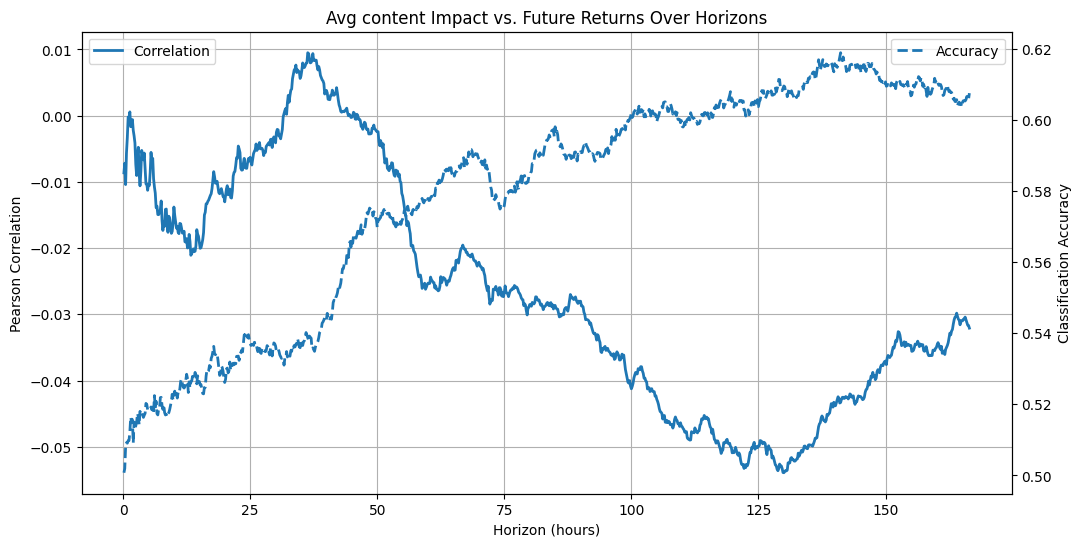

▶ Highest correlation at 2180 min (36.3 h): 0.0095
▶ Highest accuracy    at 8470 min (141.2 h): 0.6190


In [ ]:
# Example usage:
horizons = np.arange(10, 10000, 10)  # every 10m up to 2 days
find_plot_metrics_by_minute(
    horizons,
    sentiment_df=btc_crypto_sentiment,
    df_ohlcv=df_ohlcv,
    impact_col_name='content_impact',   # or 'content_impact', etc.
    impact_name='content'
)

In [ ]:
def aggregate_sentiment_per_hour(sentiment_df, time_col, impact_col):
    """
    Groups sentiment_df into hourly buckets (flooring timestamps to the hour)
    and returns a DataFrame with:
      - hour: the floored datetime (to the hour)
      - impact: the average impact of all items in that hour
    """
    df = sentiment_df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    # floor to the hour
    df['hour'] = df[time_col].dt.floor('h')
    # group and average
    agg = (
        df
        .groupby('hour')[impact_col]
        .mean()
        .reset_index()
        .rename(columns={'hour': time_col, impact_col: 'impact'})
    )
    return agg

def find_plot_metrics_by_hour(horizons, sentiment_df, df_ohlcv, impact_col_name, impact_name):
    # 1) Pre-aggregate sentiment into minute buckets
    sent_agg = aggregate_sentiment_per_hour(sentiment_df, time_col='releasedAt', impact_col=impact_col_name)
    sent_agg = sent_agg.sort_values('releasedAt')

    # 2) Prepare OHLCV
    ohlcv = df_ohlcv.copy()
    ohlcv['dateTime'] = pd.to_datetime(ohlcv['dateTime'])
    ohlcv = ohlcv.sort_values('dateTime')

    # 3) Compute all shifted returns at once (avoid fragmentation)
    return_dict = {
        f'return_{h}m': ohlcv['close'].shift(-h) / ohlcv['close'] - 1
        for h in horizons
    }
    returns_df = pd.DataFrame(return_dict, index=ohlcv.index)
    ohlcv = pd.concat([ohlcv, returns_df], axis=1)

    # 4) Loop to compute per-horizon metrics
    correlations = []
    accuracies   = []

    for h in tqdm(horizons, desc="Evaluating horizons"):
        ret_col = f'return_{h}m'

        # merge-on minute-to-minute basis
        merged = pd.merge_asof(
            sent_agg,
            ohlcv[['dateTime', ret_col]],
            left_on='releasedAt',
            right_on='dateTime',
            direction='forward',
            tolerance=pd.Timedelta('1min')
        ).dropna(subset=[ret_col])

        correlations.append( merged['impact'].corr(merged[ret_col]) )
        actual_up = merged[ret_col] > 0
        pred_up   = merged['impact'] > 0
        accuracies.append( accuracy_score(actual_up, pred_up) )

    # 5) Build metrics DataFrame & plot
    metrics_df = pd.DataFrame({
        'horizon_min': horizons,
        'horizon_hr':  horizons / 60,
        'correlation': correlations,
        'accuracy':    accuracies
    })

    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()
    ax1.plot(metrics_df['horizon_hr'], metrics_df['correlation'], label='Correlation', linewidth=2)
    ax2.plot(metrics_df['horizon_hr'], metrics_df['accuracy'],   label='Accuracy',   linestyle='--', linewidth=2)

    ax1.set_xlabel('Horizon (hours)')
    ax1.set_ylabel('Pearson Correlation')
    ax2.set_ylabel('Classification Accuracy')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True)
    plt.title(f"Avg {impact_name} Impact vs. Future Returns Over Horizons")
    plt.show()

    # 6) Print best-performing horizons
    best_corr = metrics_df.loc[metrics_df['correlation'].idxmax()]
    best_acc  = metrics_df.loc[metrics_df['accuracy'].idxmax()]

    print(f"▶ Highest correlation at {int(best_corr['horizon_min'])} min "
          f"({best_corr['horizon_hr']:.1f} h): {best_corr['correlation']:.4f}")
    print(f"▶ Highest accuracy    at {int(best_acc['horizon_min'])} min "
          f"({best_acc['horizon_hr']:.1f} h): {best_acc['accuracy']:.4f}")

Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

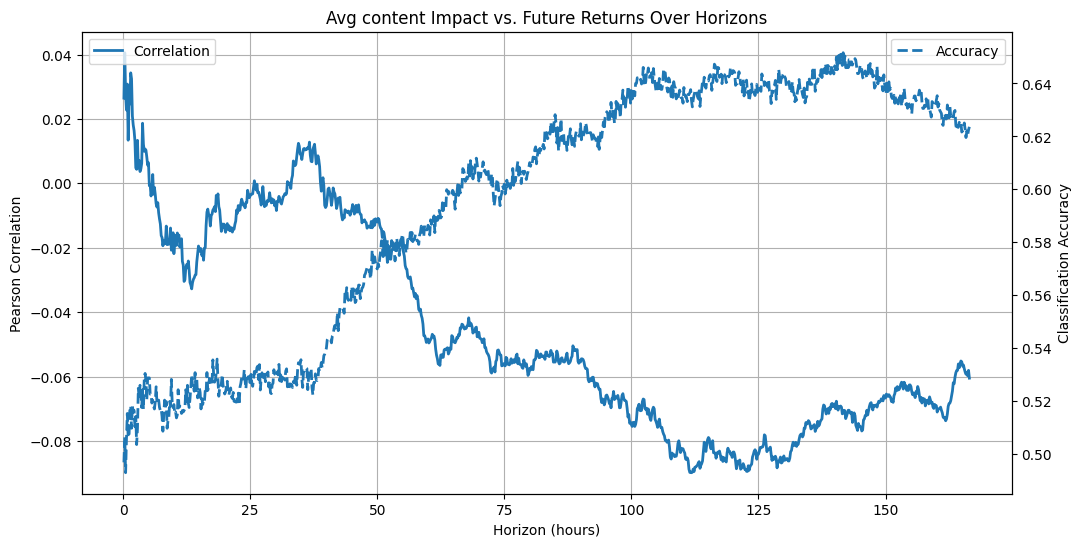

▶ Highest correlation at 20 min (0.3 h): 0.0406
▶ Highest accuracy    at 8500 min (141.7 h): 0.6516


In [ ]:
# Example usage:
horizons = np.arange(10, 10000, 10)
find_plot_metrics_by_hour(
    horizons,
    sentiment_df=btc_crypto_sentiment,
    df_ohlcv=df_ohlcv,
    impact_col_name='content_impact',
    impact_name='content'
)

Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

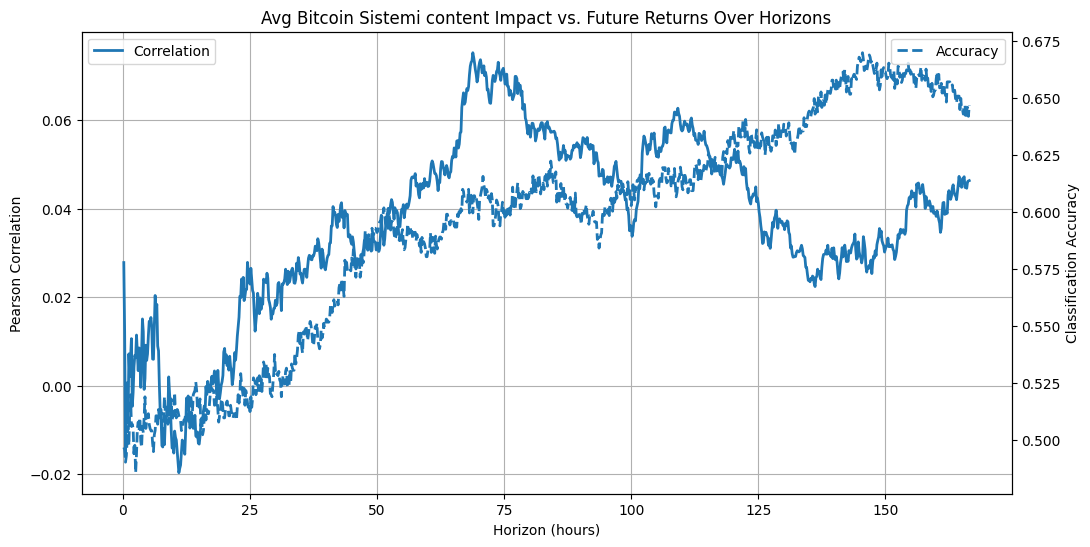

▶ Highest correlation at 4130 min (68.8 h): 0.0752
▶ Highest accuracy    at 8730 min (145.5 h): 0.6699


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

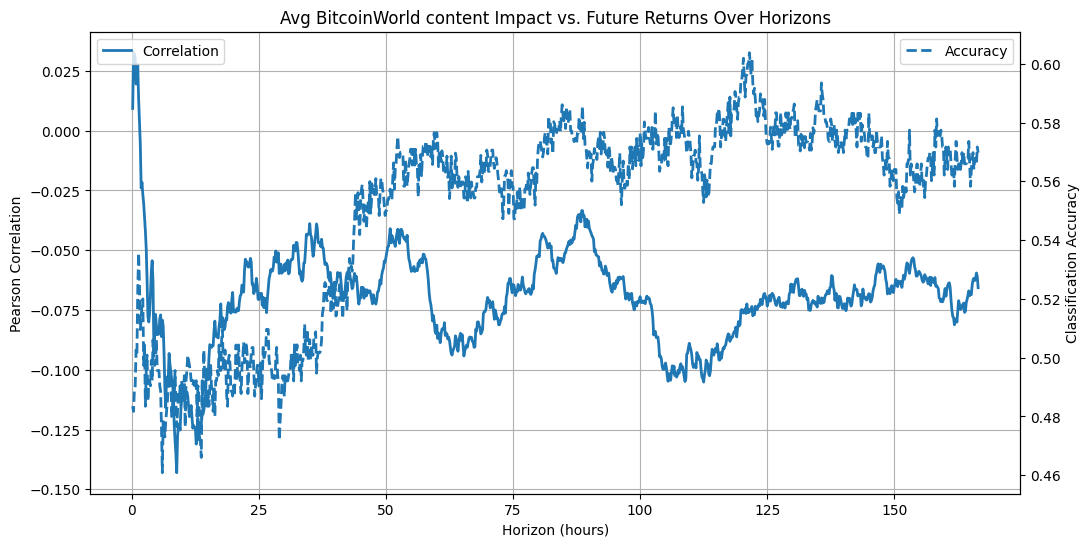

▶ Highest correlation at 20 min (0.3 h): 0.0326
▶ Highest accuracy    at 7290 min (121.5 h): 0.6038


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

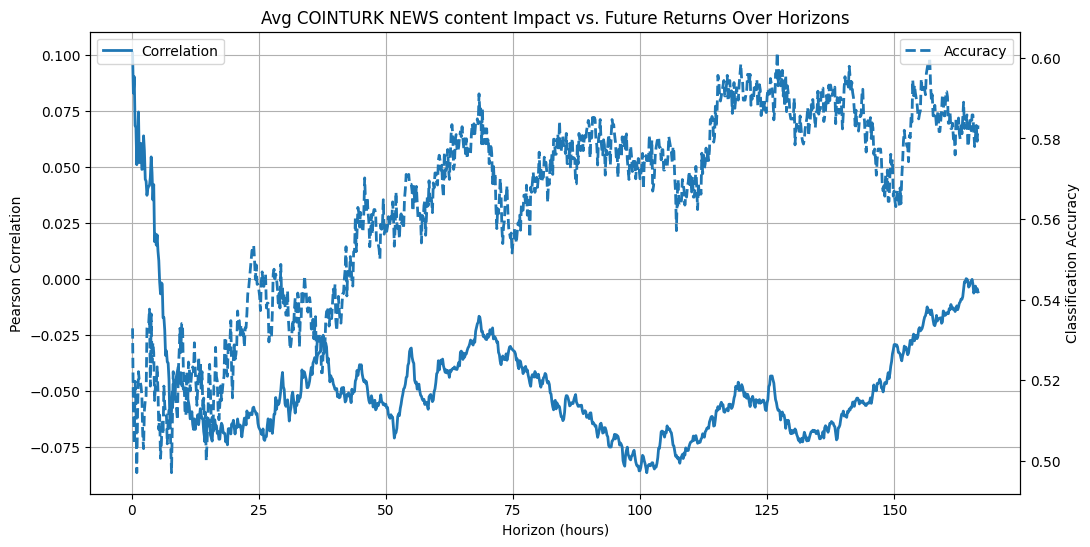

▶ Highest correlation at 10 min (0.2 h): 0.1010
▶ Highest accuracy    at 7620 min (127.0 h): 0.6013


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

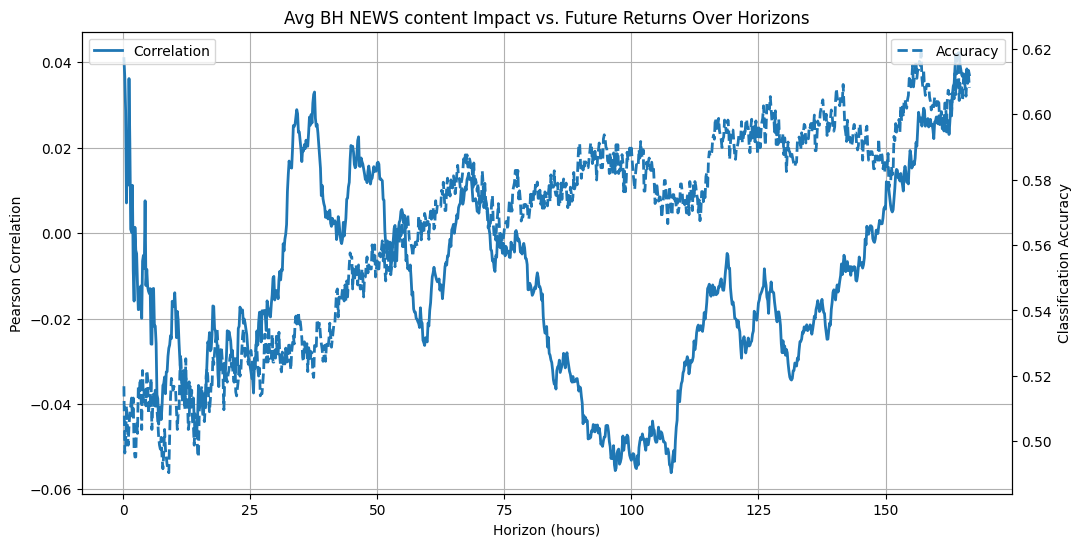

▶ Highest correlation at 9870 min (164.5 h): 0.0423
▶ Highest accuracy    at 9420 min (157.0 h): 0.6188


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

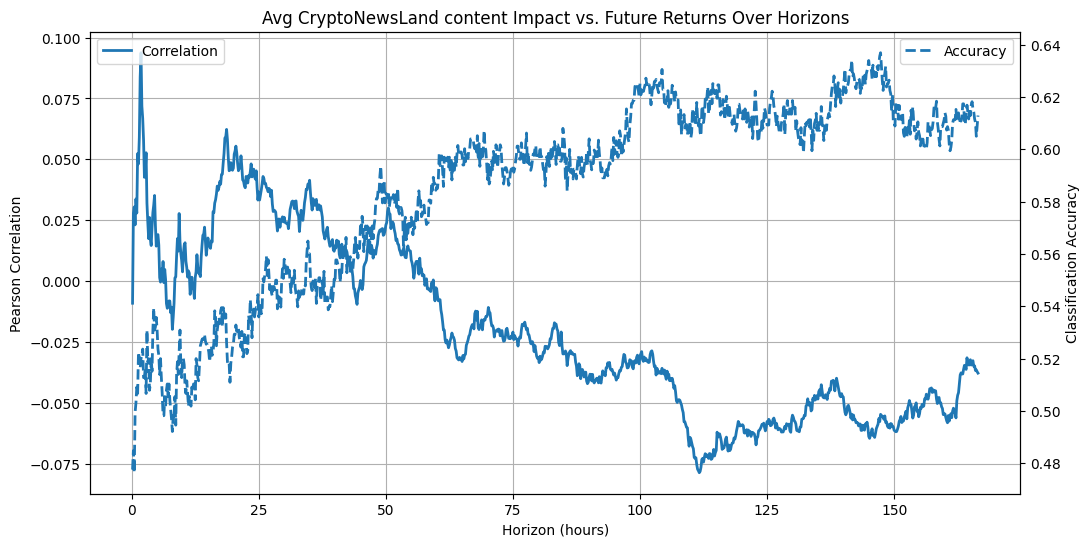

▶ Highest correlation at 110 min (1.8 h): 0.0938
▶ Highest accuracy    at 8840 min (147.3 h): 0.6370


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

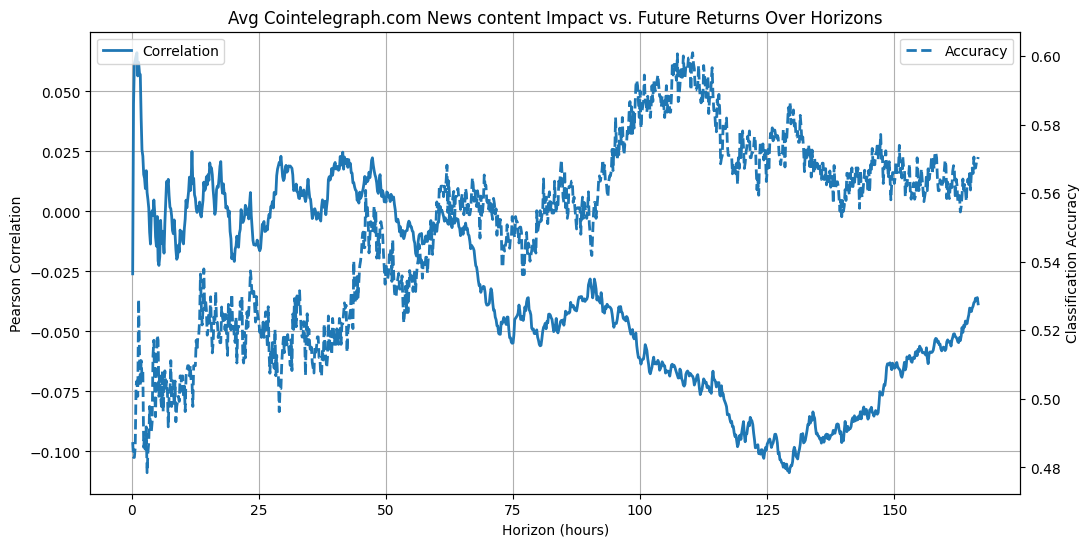

▶ Highest correlation at 60 min (1.0 h): 0.0661
▶ Highest accuracy    at 6620 min (110.3 h): 0.6009


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

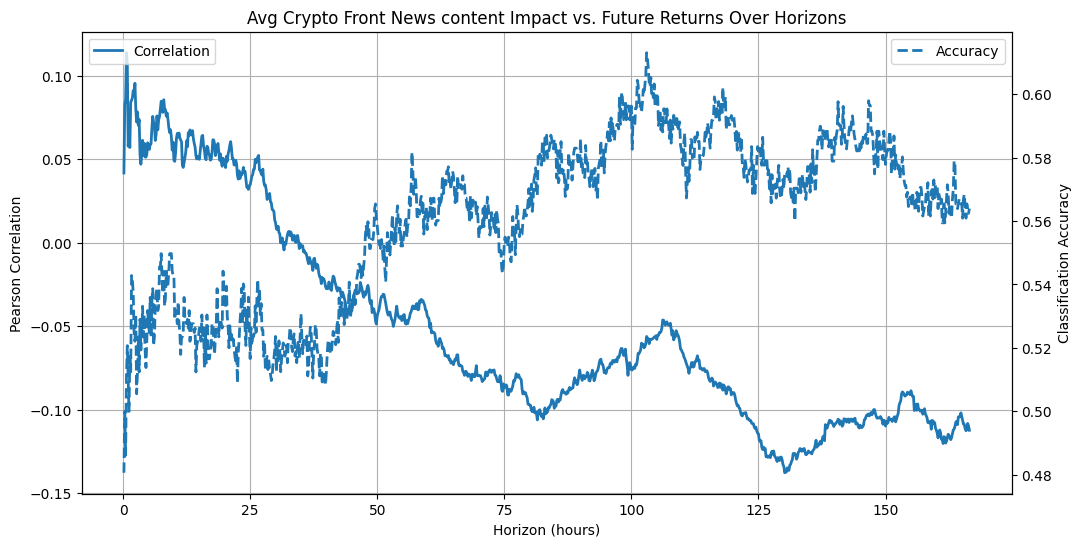

▶ Highest correlation at 40 min (0.7 h): 0.1137
▶ Highest accuracy    at 6180 min (103.0 h): 0.6130


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

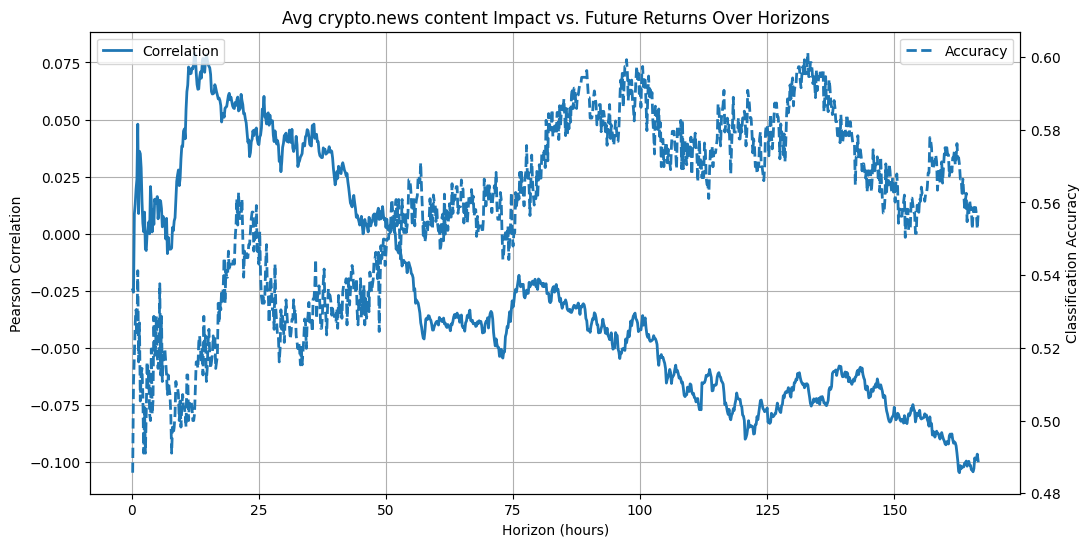

▶ Highest correlation at 740 min (12.3 h): 0.0793
▶ Highest accuracy    at 7980 min (133.0 h): 0.6012


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

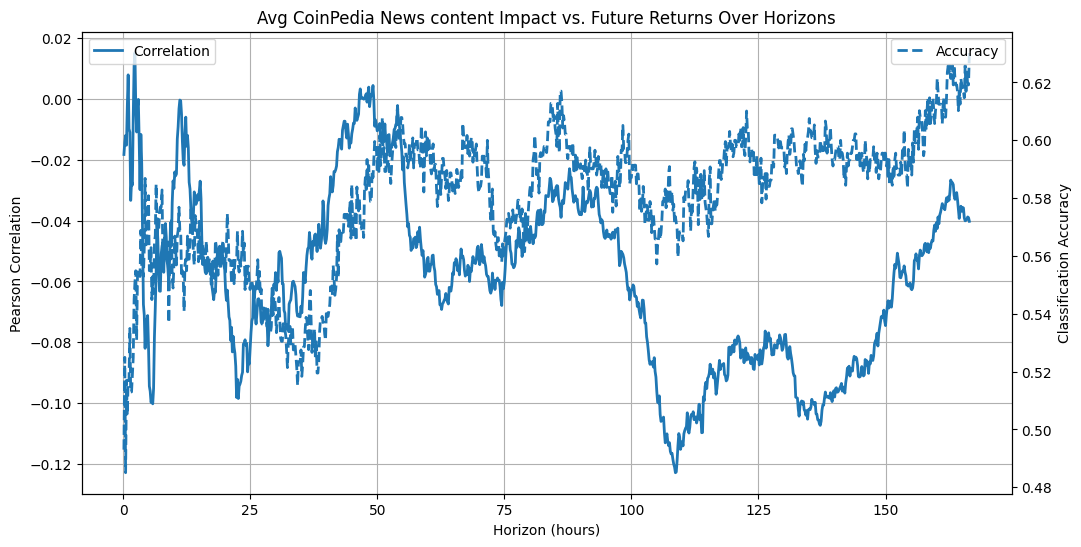

▶ Highest correlation at 140 min (2.3 h): 0.0151
▶ Highest accuracy    at 9990 min (166.5 h): 0.6303


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

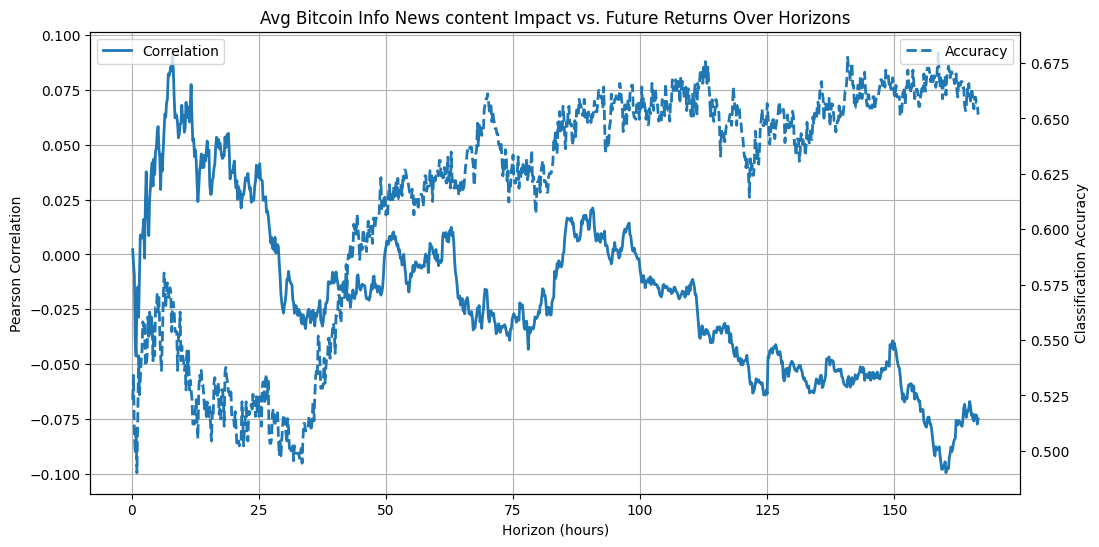

▶ Highest correlation at 480 min (8.0 h): 0.0919
▶ Highest accuracy    at 9520 min (158.7 h): 0.6797


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

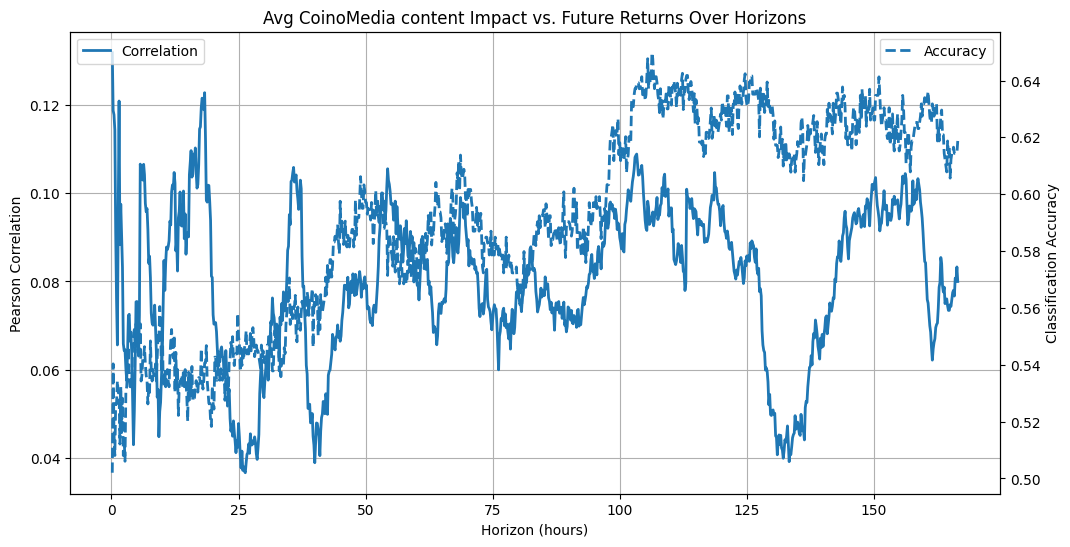

▶ Highest correlation at 10 min (0.2 h): 0.1319
▶ Highest accuracy    at 6380 min (106.3 h): 0.6498


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

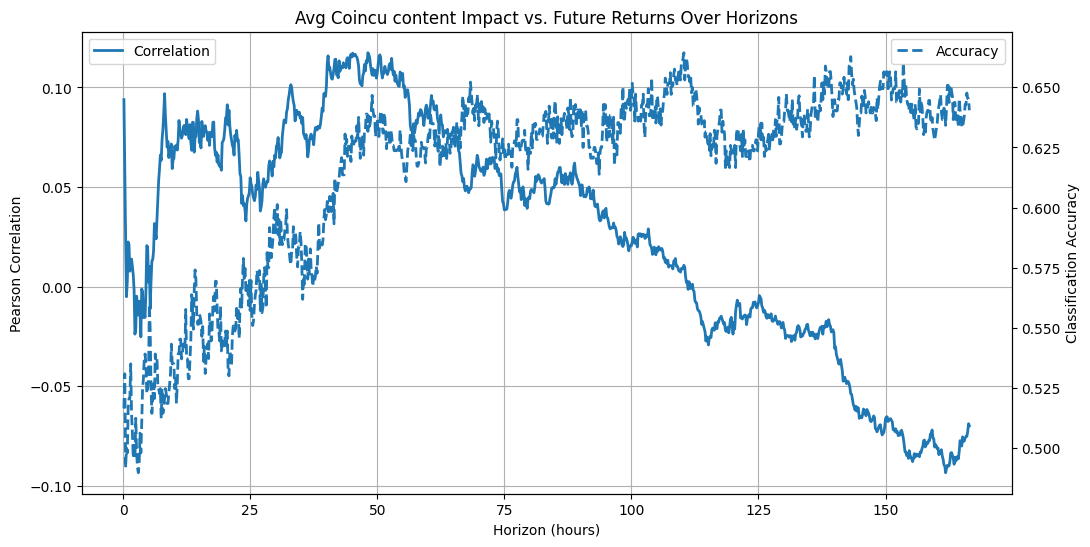

▶ Highest correlation at 2890 min (48.2 h): 0.1174
▶ Highest accuracy    at 6620 min (110.3 h): 0.6644


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

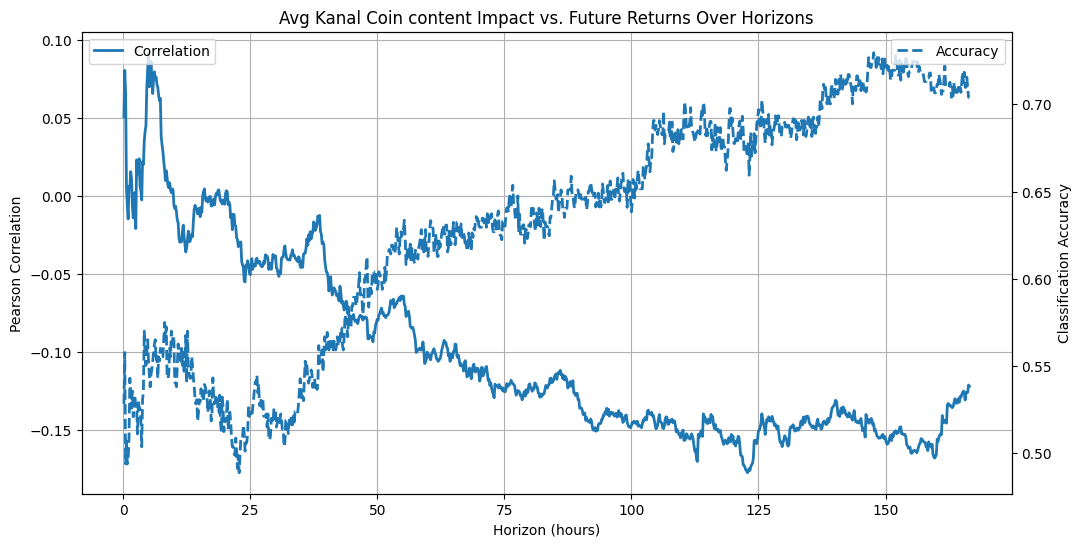

▶ Highest correlation at 300 min (5.0 h): 0.0918
▶ Highest accuracy    at 8860 min (147.7 h): 0.7296


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

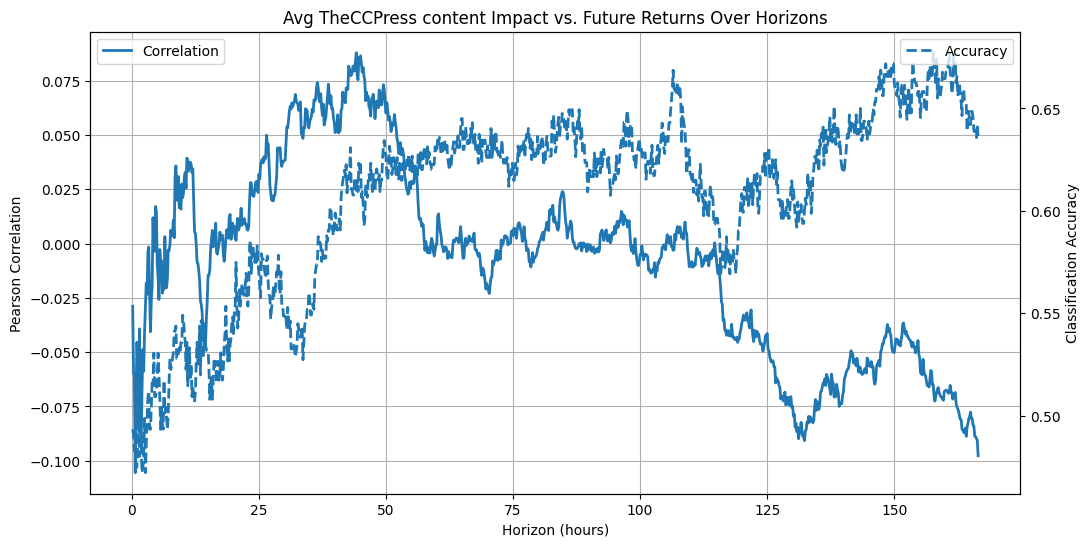

▶ Highest correlation at 2650 min (44.2 h): 0.0878
▶ Highest accuracy    at 9460 min (157.7 h): 0.6772


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

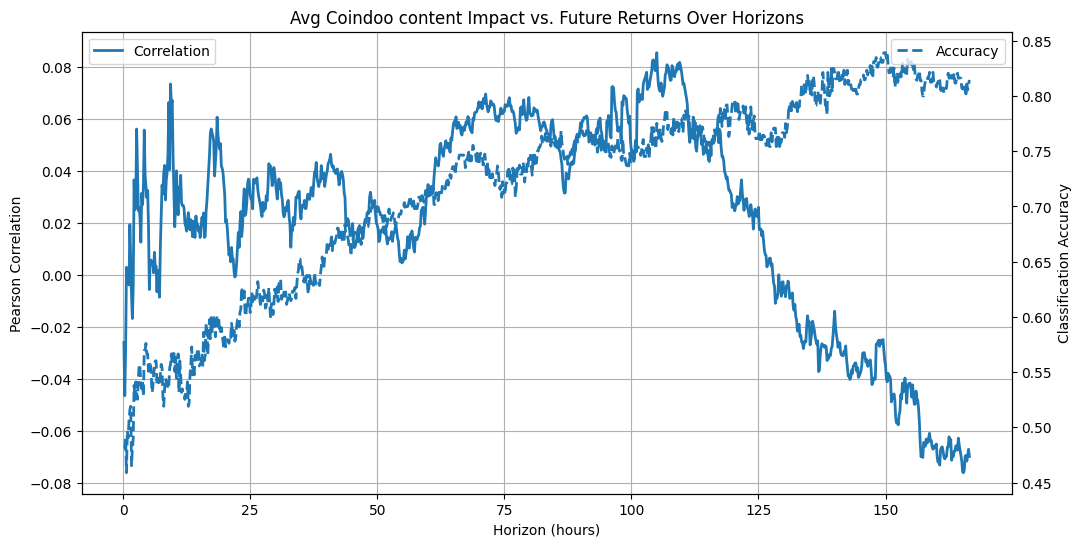

▶ Highest correlation at 6300 min (105.0 h): 0.0856
▶ Highest accuracy    at 8980 min (149.7 h): 0.8391


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

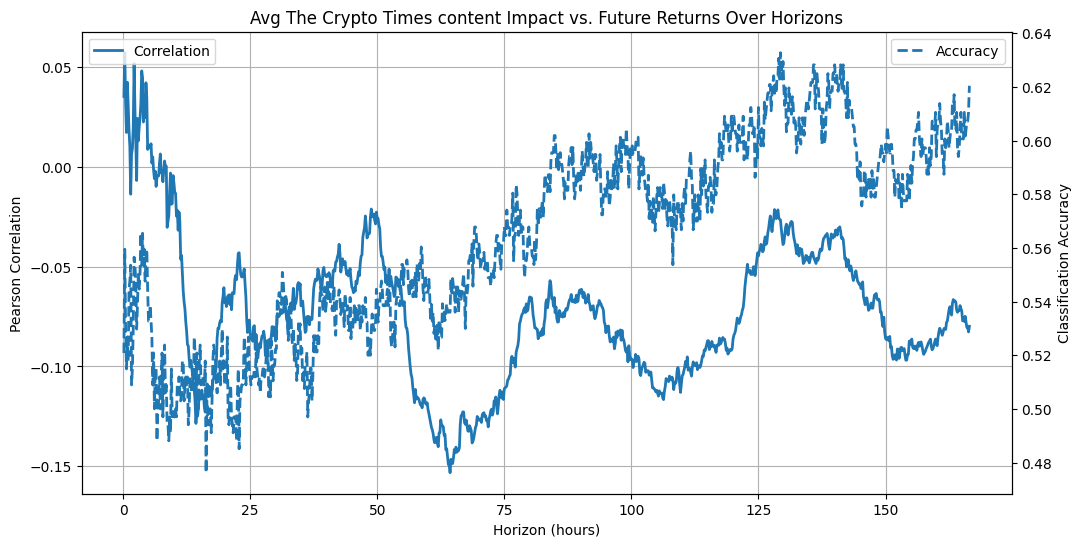

▶ Highest correlation at 20 min (0.3 h): 0.0572
▶ Highest accuracy    at 7760 min (129.3 h): 0.6328


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

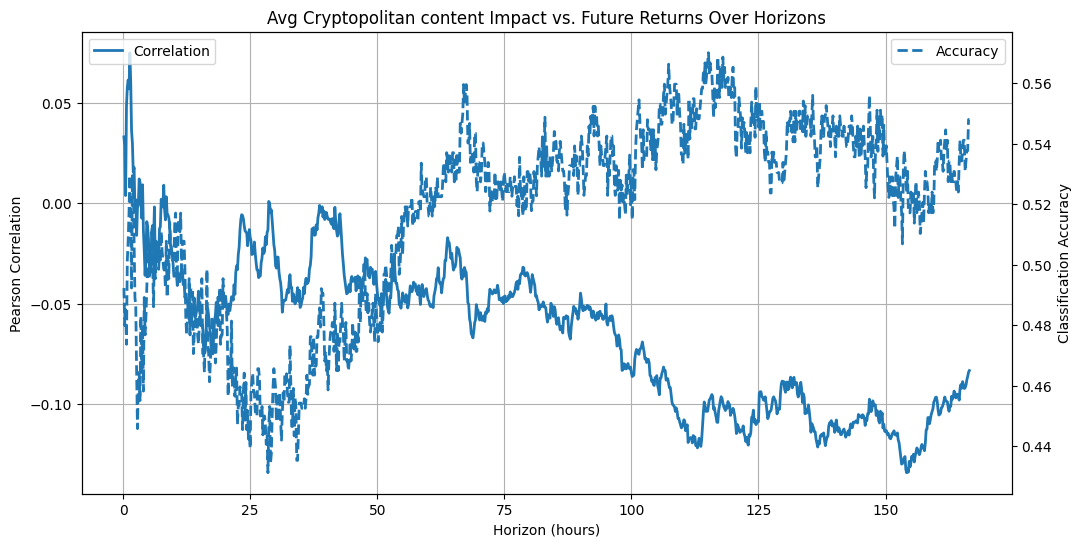

▶ Highest correlation at 80 min (1.3 h): 0.0748
▶ Highest accuracy    at 6910 min (115.2 h): 0.5700


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

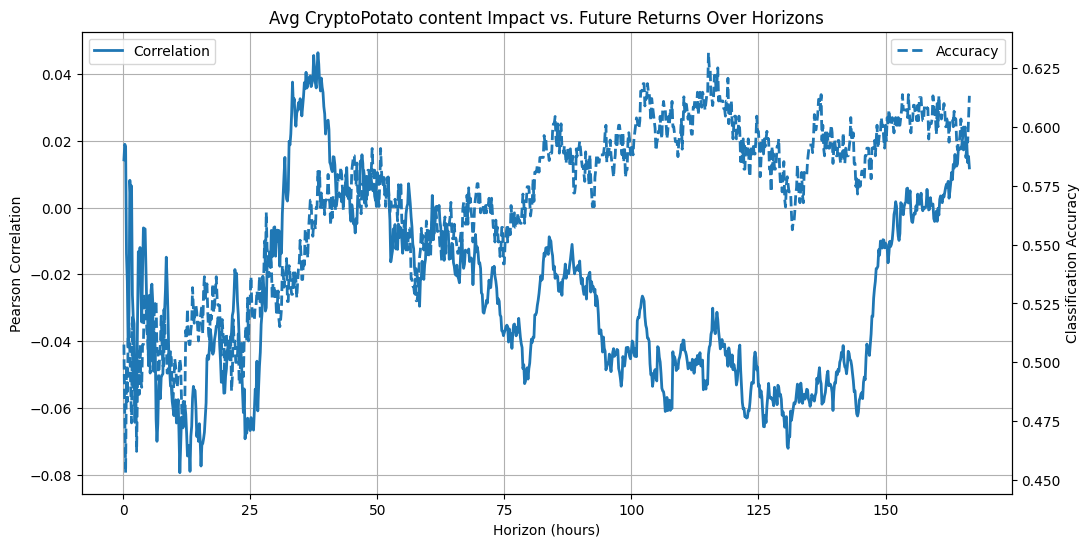

▶ Highest correlation at 2300 min (38.3 h): 0.0464
▶ Highest accuracy    at 6910 min (115.2 h): 0.6314


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

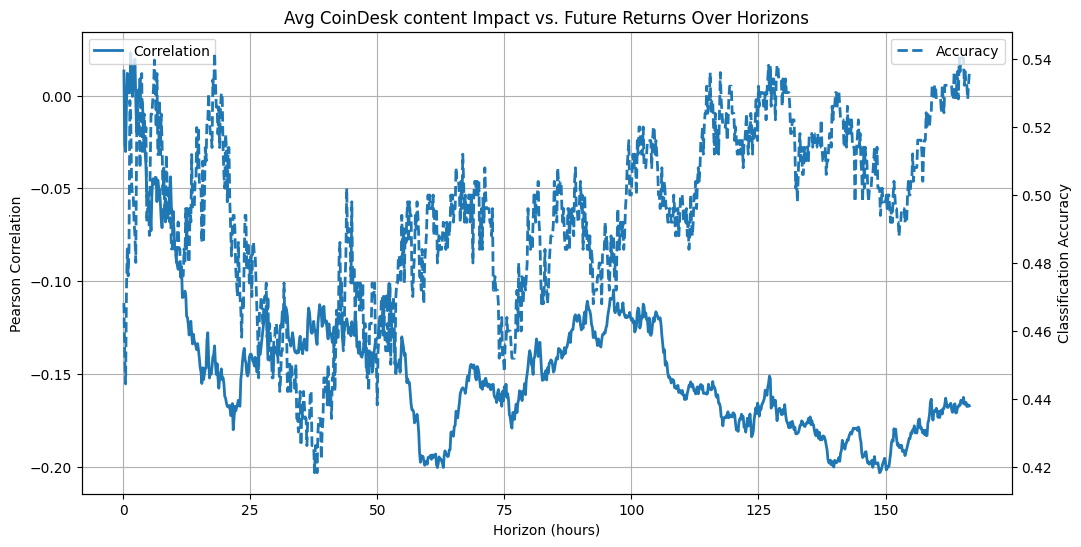

▶ Highest correlation at 90 min (1.5 h): 0.0231
▶ Highest accuracy    at 1080 min (18.0 h): 0.5418


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

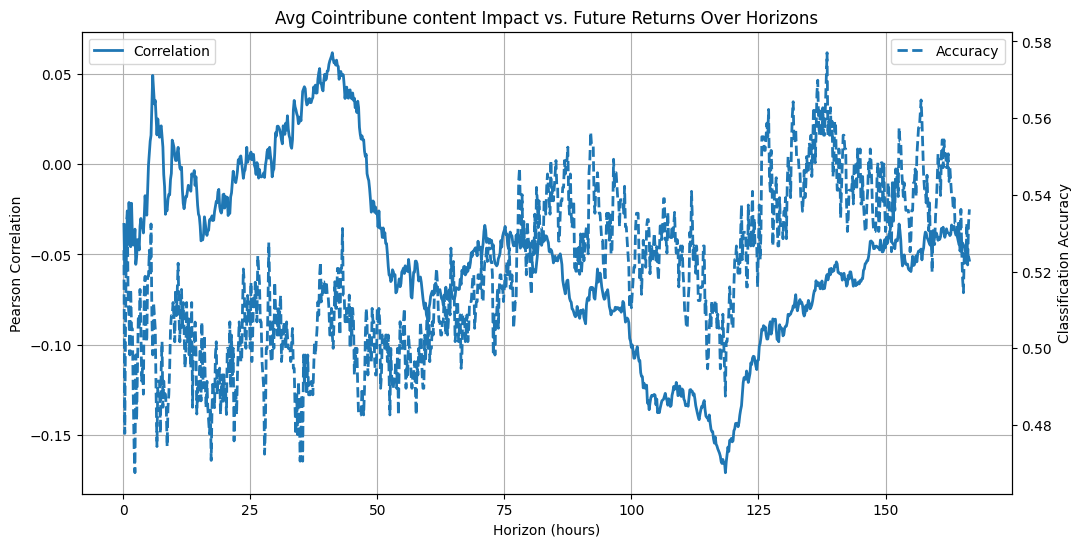

▶ Highest correlation at 2470 min (41.2 h): 0.0616
▶ Highest accuracy    at 8310 min (138.5 h): 0.5771


In [ ]:
for source in top20_sources:
    find_plot_metrics_by_hour(
        horizons,
        btc_crypto_sentiment[btc_crypto_sentiment['sourceName'] == source],
        df_ohlcv,
        "content_impact",
        source + " content")

# Longformer and Big Bird

In [ ]:
# 1) Pin back the conflicting libraries
!pip install --upgrade packaging==23.3 fsspec==2025.3.2

# 2) Reinstall transformers without pulling in its dependencies
!pip install --upgrade --no-deps transformers

ERROR: Ignored the following yanked versions: 20.6
ERROR: Could not find a version that satisfies the requirement packaging==23.3 (from versions: 14.0, 14.1, 14.2, 14.3, 14.4, 14.5, 15.0, 15.1, 15.2, 15.3, 16.0, 16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 17.0, 17.1, 18.0, 19.0, 19.1, 19.2, 20.0, 20.1, 20.2, 20.3, 20.4, 20.5, 20.7, 20.8, 20.9, 21.0, 21.1, 21.2, 21.3, 22.0, 23.0, 23.1, 23.2, 24.0, 24.1, 24.2, 25.0)
ERROR: No matching distribution found for packaging==23.3


In [ ]:
from datasets import load_dataset, ClassLabel, DatasetDict, Dataset
import ast
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    default_data_collator,
)
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive
import pandas as pd

using https://www.kaggle.com/datasets/oliviervha/crypto-news dataset for finetuning

In [ ]:
drive.mount('/content/drive')

csv_path = '/content/drive/MyDrive/cryptonews.csv'

news_df_finetuning = pd.read_csv(csv_path)

print(news_df_finetuning.shape)
news_df_finetuning.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(31037, 7)


date                                          sentiment  \
0  2023-12-19 06:40:41  {'class': 'negative', 'polarity': -0.1, 'subje...   
1  2023-12-19 06:03:24  {'class': 'neutral', 'polarity': 0.0, 'subject...   
2  2023-12-19 05:55:14  {'class': 'positive', 'polarity': 0.05, 'subje...   
3  2023-12-19 05:35:26  {'class': 'positive', 'polarity': 0.5, 'subjec...   
4  2023-12-19 05:31:08  {'class': 'neutral', 'polarity': 0.0, 'subject...   

          source     subject  \
0     CryptoNews     altcoin   
1     CryptoNews  blockchain   
2     CryptoNews  blockchain   
3  CoinTelegraph  blockchain   
4  CoinTelegraph    ethereum   

                                                text  \
0  Grayscale CEO Michael Sonnenshein believes the...   
1  In an exclusive interview with CryptoNews, Man...   
2  According to the Federal Court ruling on Decem...   
3  Some suggest EVM inscriptions are the latest w...   
4  A decision by bloXroute Labs to start censorin...   

                                               title  \
0  Grayscale CEO Calls for Simultaneous Approval ...   
1  Indian Government is Actively Collaborating Wi...   
2  Judge Approves Settlement: Binance to Pay $1.5...   
3  Why a gold rush for inscriptions has broken ha...   
4  ‘Concerning precedent’ — bloXroute Labs' MEV r...   

                                                 url  
0  https://cryptonews.comhttps://cryptonews.com/n...  
1  https://cryptonews.comhttps://cryptonews.com/n...  
2  https://cryptonews.comhttps://cryptonews.com/n...  
3  https://cointelegraph.com/news/inscriptions-ev...  
4  https://cointelegraph.com/news/concerning-prec...

In [ ]:
# 1) Load & preprocess into news_df_finetuning
news_df_finetuning = pd.read_csv("/content/drive/MyDrive/cryptonews.csv")
news_df_finetuning['sentiment_dict'] = news_df_finetuning['sentiment'] \
    .apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
news_df_finetuning['label_str'] = news_df_finetuning['sentiment_dict'] \
    .apply(lambda d: d['class'])

# 2) HuggingFace Dataset & split
hf_ds = Dataset.from_pandas(
    news_df_finetuning[['text', 'label_str']],
    preserve_index=False
)
hf_ds = hf_ds.train_test_split(test_size=0.1, seed=42)
hf_ds = DatasetDict(train=hf_ds['train'], validation=hf_ds['test'])

# 3) Cast & rename label
hf_ds = hf_ds.cast_column("label_str", ClassLabel(names=["negative","neutral","positive"]))
hf_ds = hf_ds.rename_column("label_str","labels")

# 4) Preprocess fn
def preprocess(batch, tokenizer, max_length):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_length)

# 5) Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds  = np.argmax(pred.predictions, axis=1)
    acc    = accuracy_score(labels, preds)
    p, r, f, _ = precision_recall_fscore_support(labels, preds, average="macro")
    return {"accuracy":acc, "precision":p, "recall":r, "f1_macro":f}

# 6) Collator
def collate_fn(batch):
    input_ids      = torch.tensor([ex["input_ids"] for ex in batch], dtype=torch.long)
    attention_mask = torch.tensor([ex["attention_mask"] for ex in batch], dtype=torch.long)
    labels         = torch.tensor([ex["labels"] for ex in batch], dtype=torch.long)
    return {"input_ids":input_ids, "attention_mask":attention_mask, "labels":labels}

# 7) Training loop
for model_name, backbone, max_len in [
    ("longformer-4096", "allenai/longformer-base-4096", 4096),
    ("bigbird-4096",    "google/bigbird-roberta-base",   4096),
]:
    print(f"\n=== Training {model_name} ===")
    tokenizer = AutoTokenizer.from_pretrained(backbone)
    model     = AutoModelForSequenceClassification.from_pretrained(backbone, num_labels=3)

    # a) Tokenize, dropping only "text"
    tokenized = hf_ds.map(
        lambda batch: preprocess(batch, tokenizer, max_length=max_len),
        batched=True,
        remove_columns=["text"]
    )

    # b) Prepare legacy TrainingArguments
    args = TrainingArguments(
        output_dir=f"./{model_name}-finetuned",
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=8,
        num_train_epochs=3,
        do_train=True,
        do_eval=True,
        eval_strategy="steps",
        save_strategy="steps",
        eval_steps=500,
        save_steps=500,
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        fp16=torch.cuda.is_available(),
        report_to=[],  # disable W&B
    )

    # c) Trainer with custom collator
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        tokenizer=tokenizer,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
    )

    # d) Train & evaluate
    trainer.train()
    print(trainer.evaluate())

Casting the dataset:   0%|          | 0/27933 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3104 [00:00<?, ? examples/s]


=== Training longformer-4096 ===


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/27933 [00:00<?, ? examples/s]

Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

<ipython-input-14-3caeb15a0a57>:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Initializing global attention on CLS token...
